In [3]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from numpy import log
import time
from keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from keras.layers import Dense, LeakyReLU
from keras.activations import elu
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import LeakyReLU, ELU
# from arch import arch_model
from sklearn.preprocessing import StandardScaler
from keras.layers import GRU, Dense, Dropout
#importing necessary libraries
from math import log, exp
from datetime import datetime
from numpy import log, exp


In [4]:
class EuropeanOptionBS:
    def __init__(self, S, K, T, r, q, sigma, Type):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.Type = Type
        self.d1 = self.d1()
        self.d2 = self.d2()
        self.price = self.price()

    def d1(self):
        d1 = (math.log(self.S / self.K) +
              (self.r - self.q + 0.5 * (self.sigma ** 2)) * self.T) / \
             (self.sigma * math.sqrt(self.T))
        return d1

    def d2(self):
        d2 = self.d1 - self.sigma * math.sqrt(self.T)
        return d2

    def price(self):
        if self.Type == "Call":
            price = self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1) - \
                    self.K * math.exp(-self.r * self.T) * norm.cdf(self.d2)
        if self.Type == "Put":
            price = self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2) - \
                    self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)
        return price

# real data

In [5]:


# Function to process AAPL CSV data (adapted from original data_cleaning function)
def data_cleaning_aapl(df_subset, maturity_date):
    """
    Clean and process AAPL options data subset.
    Adapted from original data_cleaning() function to work with AAPL CSV format.
    Follows exact same logic as original notebook.
    """
    df = df_subset.copy()
    
    # Step 1: Ensure column names are clean (already done in loading, but ensure)
    df.columns = df.columns.str.strip().str.replace('[', '').str.replace(']', '')
    
    # Step 2: Rename columns to match expected format (same as original)
    # Original: {"Price~" : "underlying_stockprice", 'Last' : 'option_price'}
    columns = {
        "UNDERLYING_LAST": "underlying_stockprice",
        'C_LAST': 'option_price',
        'QUOTE_DATE': 'Time'
    }
    df.rename(columns=columns, inplace=True)
    
    # Step 3: Handle IV conversion (same as original)
    # Original: df[column_to_convert] = df[column_to_convert].str.rstrip('%').astype('float') / 100.0
    column_to_convert = 'C_IV'
    if column_to_convert in df.columns:
        # Remove rows with missing IV
        df = df[df[column_to_convert].notna()]
        df[column_to_convert] = df[column_to_convert].replace('', np.nan)
        df[column_to_convert] = pd.to_numeric(df[column_to_convert], errors='coerce')
        df = df[df[column_to_convert].notna()]
        df = df[df[column_to_convert] > 0]
        
        # Convert IV to decimal (same as original logic)
        if len(df) > 0 and df[column_to_convert].max() > 1:
            df[column_to_convert] = df[column_to_convert] / 100.0
        df.rename(columns={column_to_convert: 'IV'}, inplace=True)
    
    # Step 4: Convert Time to datetime (same as original: format='%m/%d/%Y')
    # AAPL format: '2022-07-01'
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df[df['Time'].notna()]
    
    # Step 5: Convert numeric columns
    df['underlying_stockprice'] = pd.to_numeric(df['underlying_stockprice'], errors='coerce')
    df['option_price'] = pd.to_numeric(df['option_price'], errors='coerce')
    df['Strike'] = pd.to_numeric(df['STRIKE'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['C_VOLUME'], errors='coerce')
    
    # Step 6: Drop unnecessary columns (same as original)
    for col in ['Open', 'High', 'Low', 'Change', '%Chg', 'Bid', 'Ask', 'Open Int', 'Delta', 
                'Gamma', 'Theta', 'Vega', 'Rho', 'Theo', 'STRIKE', 'C_VOLUME', 'QUOTE_DATE',
                'C_BID', 'C_ASK', 'P_BID', 'P_ASK', 'C_SIZE', 'P_SIZE']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    
    # Step 7: Sort by Time (same as original)
    df.sort_values(by='Time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Step 8: Basic filtering (same as original)
    df = df[df['underlying_stockprice'] > 0]
    r = 0.0516
    df['r'] = 0.0516
    
    # Step 9: Calculate Maturity (same as original: (maturity_date - df['Time']).dt.days / 252)
    df['Maturity'] = (maturity_date - df['Time']).dt.days 
    df['Maturity'] = df['Maturity'] / 252
    
    # Step 10: Feature Engineering (same as original)
    df['C/S'] = df['option_price'] / df['underlying_stockprice']
    df['Monyness'] = df['underlying_stockprice'] / df['Strike']
    df['K/S'] = df['Strike'] / df['underlying_stockprice']
    
    # Step 11: Data Filtering (same as original)
    df = df[df['Volume'] != 0]
    df = df[df['option_price'] != 0]
    df = df[df['option_price'] >= 0.1]
    df = df[df['Maturity'] <= 2.4]
    df = df[df['Maturity'] > 0]
    df = df.dropna()
    
    return df

In [6]:
# Load the AAPL CSV file (same as original notebook loads multiple CSVs)
print("Loading AAPL options data...")
df_raw = pd.read_csv('aapl_2021_2023.csv', low_memory=False)

# Strip brackets from column names
df_raw.columns = df_raw.columns.str.strip().str.replace('[', '').str.replace(']', '')

print(f"✓ Loaded {len(df_raw):,} rows")
print(f"✓ Date range: {df_raw['QUOTE_DATE'].min()} to {df_raw['QUOTE_DATE'].max()}")
print(f"✓ Columns: {len(df_raw.columns)}")

# Convert QUOTE_DATE to datetime for grouping
df_raw['QUOTE_DATE'] = pd.to_datetime(df_raw['QUOTE_DATE'], errors='coerce')
df_raw = df_raw[df_raw['QUOTE_DATE'].notna()]

# Group data by year-month (similar to original notebook's date groups)
# This mimics the original structure: 20240315, 20240419, 20240503, 20240517
df_raw['YearMonth'] = df_raw['QUOTE_DATE'].dt.to_period('M')

# Get unique year-months
unique_months = sorted(df_raw['YearMonth'].unique())
print(f"\n✓ Found {len(unique_months)} unique months")
print(f"✓ Sample months: {unique_months[:10]}")

# Use data spanning from late 2021 through early 2023 to match original's ~2 year span
# Original notebook shows data from Nov 2022 to July 2024 (~20 months)
# We'll use Nov 2021 through Mar 2023 (~17 months) to get similar time coverage
start_date = pd.Timestamp('2021-11-01')
end_date = pd.Timestamp('2023-03-31')

df_raw_filtered = df_raw[
    (df_raw['QUOTE_DATE'] >= start_date) & 
    (df_raw['QUOTE_DATE'] <= end_date)
].copy()

unique_months_filtered = sorted(df_raw_filtered['YearMonth'].unique())
print(f"\n✓ Filtered data: {len(df_raw_filtered):,} rows across {len(unique_months_filtered)} months")
print(f"✓ Date range: {df_raw_filtered['QUOTE_DATE'].min()} to {df_raw_filtered['QUOTE_DATE'].max()}")
print(f"✓ Available months: {unique_months_filtered}")


Loading AAPL options data...
✓ Loaded 548,163 rows
✓ Date range:  2021-01-04 to  2023-03-31
✓ Columns: 33

✓ Found 27 unique months
✓ Sample months: [Period('2021-01', 'M'), Period('2021-02', 'M'), Period('2021-03', 'M'), Period('2021-04', 'M'), Period('2021-05', 'M'), Period('2021-06', 'M'), Period('2021-07', 'M'), Period('2021-08', 'M'), Period('2021-09', 'M'), Period('2021-10', 'M')]

✓ Filtered data: 346,881 rows across 17 months
✓ Date range: 2021-11-01 00:00:00 to 2023-03-31 00:00:00
✓ Available months: [Period('2021-11', 'M'), Period('2021-12', 'M'), Period('2022-01', 'M'), Period('2022-02', 'M'), Period('2022-03', 'M'), Period('2022-04', 'M'), Period('2022-05', 'M'), Period('2022-06', 'M'), Period('2022-07', 'M'), Period('2022-08', 'M'), Period('2022-09', 'M'), Period('2022-10', 'M'), Period('2022-11', 'M'), Period('2022-12', 'M'), Period('2023-01', 'M'), Period('2023-02', 'M'), Period('2023-03', 'M')]


In [7]:
# Process data by month groups (similar to original notebook's date groups)
# We'll use the last day of each month as maturity_date (or use EXPIRE_DATE from data)

# Use ALL months in the filtered range to match original's longer time span
# This will give us ~17 months of data (Nov 2021 - Mar 2023) similar to original's ~20 months
selected_months = unique_months_filtered

print(f"Processing {len(selected_months)} month groups (spanning ~{len(selected_months)} months):")
for month in selected_months:
    print(f"  - {month}")

# Dictionary to hold processed DataFrames (like original: processed_2024419, etc.)
processed_groups = {}


Processing 17 month groups (spanning ~17 months):
  - 2021-11
  - 2021-12
  - 2022-01
  - 2022-02
  - 2022-03
  - 2022-04
  - 2022-05
  - 2022-06
  - 2022-07
  - 2022-08
  - 2022-09
  - 2022-10
  - 2022-11
  - 2022-12
  - 2023-01
  - 2023-02
  - 2023-03


In [8]:
# Process each month group (similar to original notebook's loop)
for month_period in selected_months:
    # Get data for this month from the filtered dataset
    month_data = df_raw_filtered[df_raw_filtered['YearMonth'] == month_period].copy()
    
    # Use the last day of the month as maturity_date (or could use max EXPIRE_DATE)
    # Convert Period to datetime for maturity_date calculation
    month_end = month_period.to_timestamp() + pd.offsets.MonthEnd(0)
    maturity_date = datetime(month_end.year, month_end.month, month_end.day)
    
    # Process this month's data
    print(f"\nProcessing {month_period} (maturity_date: {maturity_date.date()})...")
    processed_df = data_cleaning_aapl(month_data, maturity_date)
    
    # Store in dictionary (like original: processed_2024419[df_name])
    group_name = f"processed_{month_period.strftime('%Y%m')}"
    processed_groups[group_name] = processed_df
    
    print(f"  ✓ Processed {len(processed_df):,} rows")

print(f"\n✓ Total groups processed: {len(processed_groups)}")



Processing 2021-11 (maturity_date: 2021-11-30)...
  ✓ Processed 11,391 rows

Processing 2021-12 (maturity_date: 2021-12-31)...
  ✓ Processed 10,154 rows

Processing 2022-01 (maturity_date: 2022-01-31)...
  ✓ Processed 10,706 rows

Processing 2022-02 (maturity_date: 2022-02-28)...
  ✓ Processed 8,470 rows

Processing 2022-03 (maturity_date: 2022-03-31)...
  ✓ Processed 9,712 rows

Processing 2022-04 (maturity_date: 2022-04-30)...
  ✓ Processed 8,326 rows

Processing 2022-05 (maturity_date: 2022-05-31)...
  ✓ Processed 8,378 rows

Processing 2022-06 (maturity_date: 2022-06-30)...
  ✓ Processed 6,846 rows

Processing 2022-07 (maturity_date: 2022-07-31)...
  ✓ Processed 8,374 rows

Processing 2022-08 (maturity_date: 2022-08-31)...
  ✓ Processed 9,542 rows

Processing 2022-09 (maturity_date: 2022-09-30)...
  ✓ Processed 10,346 rows

Processing 2022-10 (maturity_date: 2022-10-31)...
  ✓ Processed 8,986 rows

Processing 2022-11 (maturity_date: 2022-11-30)...
  ✓ Processed 9,808 rows

Process

In [9]:
# Combine each group's DataFrames (similar to original: combined_df1, combined_df2, etc.)
# Since we have multiple groups, combine them similar to original notebook

combined_dfs = []
group_names = sorted(processed_groups.keys())

for i, group_name in enumerate(group_names, 1):
    if len(processed_groups[group_name]) > 0:
        combined_df = pd.concat([processed_groups[group_name]], ignore_index=True)
        combined_dfs.append(combined_df)
        print(f"combined_df{i} ({group_name}): {len(combined_df):,} rows")

# Final combination (like original: combined_df = pd.concat([combined_df1, combined_df2, combined_df3, combined_df4]))
if len(combined_dfs) > 0:
    combined_df = pd.concat(combined_dfs, ignore_index=True)
    print(f"\n✓ Final combined_df: {len(combined_df):,} rows")
    print(f"✓ Shape: {combined_df.shape}")
else:
    print("⚠ No data to combine!")
    combined_df = pd.DataFrame()


combined_df1 (processed_202111): 11,391 rows
combined_df2 (processed_202112): 10,154 rows
combined_df3 (processed_202201): 10,706 rows
combined_df4 (processed_202202): 8,470 rows
combined_df5 (processed_202203): 9,712 rows
combined_df6 (processed_202204): 8,326 rows
combined_df7 (processed_202205): 8,378 rows
combined_df8 (processed_202206): 6,846 rows
combined_df9 (processed_202207): 8,374 rows
combined_df10 (processed_202208): 9,542 rows
combined_df11 (processed_202209): 10,346 rows
combined_df12 (processed_202210): 8,986 rows
combined_df13 (processed_202211): 9,808 rows
combined_df14 (processed_202212): 10,202 rows
combined_df15 (processed_202301): 9,800 rows
combined_df16 (processed_202302): 8,728 rows
combined_df17 (processed_202303): 8,630 rows

✓ Final combined_df: 158,399 rows
✓ Shape: (158399, 33)


In [10]:
# Create final data variable (same as original: data = combined_df.copy())
if len(combined_df) > 0:
    data = combined_df.copy()
    
    # Sorting the combined DataFrame by 'Time' (same as original)
    data.sort_values(by='Time', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    print(f"✓ Final data: {len(data):,} rows")
    print(f"✓ Date range: {data['Time'].min()} to {data['Time'].max()}")
    print(f"✓ Columns: {data.columns.tolist()}")
else:
    data = pd.DataFrame()
    print("⚠ No data available!")


✓ Final data: 158,399 rows
✓ Date range: 2021-11-01 00:00:00 to 2023-03-30 00:00:00
✓ Columns: ['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'Time', 'QUOTE_TIME_HOURS', 'underlying_stockprice', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'IV', 'option_price', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'YearMonth', 'Strike', 'Volume', 'r', 'Maturity', 'C/S', 'Monyness', 'K/S']


In [11]:
# Calculate log returns and GARCH conditional volatility (same as original notebook)
if len(data) > 0:
    # Calculate log returns properly - need to use unique dates only
    # Since multiple options can have the same date/stock price, we need to calculate
    # log returns on unique dates first, then merge back
    
    # Get unique dates and their stock prices
    unique_dates = data[['Time', 'underlying_stockprice']].drop_duplicates(subset=['Time'])
    unique_dates = unique_dates.sort_values(by='Time').reset_index(drop=True)
    
    # Calculate log returns on unique dates
    unique_dates['log_return'] = np.log(unique_dates['underlying_stockprice'] / unique_dates['underlying_stockprice'].shift(1))
    
    # Merge log returns back to original dataframe
    data = data.merge(unique_dates[['Time', 'log_return']], on='Time', how='left', suffixes=('', '_daily'))
    
    # Drop the old log_return column if it exists and rename the new one
    if 'log_return' in data.columns and 'log_return_daily' in data.columns:
        data = data.drop(columns=['log_return'])
        data = data.rename(columns={'log_return_daily': 'log_return'})
    elif 'log_return_daily' in data.columns:
        data = data.rename(columns={'log_return_daily': 'log_return'})
    
    # Drop rows where log_return is NaN (first row of each date group)
    data = data.dropna(subset=['log_return'])
    
    print(f"✓ Data after log return calculation: {len(data):,} rows")
    print(f"✓ Log return statistics:")
    print(data['log_return'].describe())
    
    # Fit a GARCH(1,1) model (same as original)
    try:
        from arch import arch_model
        # Use unique log returns for GARCH fitting (one per day)
        unique_returns = unique_dates['log_return'].dropna().values
        model = arch_model(unique_returns, vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp='off')
        
        # Create conditional volatility dataframe and merge back
        cond_vol_df = pd.DataFrame({
            'Time': unique_dates['Time'].values,
            'cond_vol': garch_fit.conditional_volatility
        })
        data = data.merge(cond_vol_df, on='Time', how='left')
        
        print("✓ GARCH conditional volatility calculated")
    except ImportError:
        print("⚠ GARCH library not installed - using IV as cond_vol")
        data['cond_vol'] = data['IV']
    except Exception as e:
        print(f"⚠ GARCH error: {e} - using IV as cond_vol")
        data['cond_vol'] = data['IV']
else:
    print("⚠ Cannot calculate log returns - no data")


✓ Data after log return calculation: 157,919 rows
✓ Log return statistics:
count    157919.000000
mean          0.000442
std           0.021600
min          -0.080232
25%          -0.012790
50%           0.000216
75%           0.015023
max           0.084146
Name: log_return, dtype: float64
⚠ GARCH library not installed - using IV as cond_vol


In [12]:
# Save to combine.csv (same as original notebook)
if len(data) > 0:
    data.to_csv('combine.csv', index=False)
    print(f"\n✓ SUCCESS! Data saved to combine.csv")
    print(f"✓ Final dataset: {len(data):,} rows, {len(data.columns)} columns")
    print(f"\n✓ Columns saved:")
    for i, col in enumerate(data.columns.tolist(), 1):
        print(f"  {i:2d}. {col}")
else:
    print("\n✗ ERROR: Cannot save - no data available!")



✓ SUCCESS! Data saved to combine.csv
✓ Final dataset: 157,919 rows, 35 columns

✓ Columns saved:
   1. QUOTE_UNIXTIME
   2. QUOTE_READTIME
   3. Time
   4. QUOTE_TIME_HOURS
   5. underlying_stockprice
   6. EXPIRE_DATE
   7. EXPIRE_UNIX
   8. DTE
   9. C_DELTA
  10. C_GAMMA
  11. C_VEGA
  12. C_THETA
  13. C_RHO
  14. IV
  15. option_price
  16. P_LAST
  17. P_DELTA
  18. P_GAMMA
  19. P_VEGA
  20. P_THETA
  21. P_RHO
  22. P_IV
  23. P_VOLUME
  24. STRIKE_DISTANCE
  25. STRIKE_DISTANCE_PCT
  26. YearMonth
  27. Strike
  28. Volume
  29. r
  30. Maturity
  31. C/S
  32. Monyness
  33. K/S
  34. log_return
  35. cond_vol


In [13]:
from IPython.display import display, Markdown

display(Markdown("```\n" + "="*60 + "\nDATA SUMMARY\n" + "="*60 + "\n```"))
display(Markdown(f"**Shape:** `{data.shape}`"))
display(data.head())
display(Markdown("**Null values per column:**"))
display(data.isnull().sum())

```
============================================================
DATA SUMMARY
============================================================
```

**Shape:** `(157919, 35)`

QUOTE_UNIXTIME     QUOTE_READTIME       Time  QUOTE_TIME_HOURS  \
480      1635883200   2021-11-02 16:00 2021-11-02              16.0   
481      1635883200   2021-11-02 16:00 2021-11-02              16.0   
482      1635883200   2021-11-02 16:00 2021-11-02              16.0   
483      1635883200   2021-11-02 16:00 2021-11-02              16.0   
484      1635883200   2021-11-02 16:00 2021-11-02              16.0   

     underlying_stockprice  EXPIRE_DATE  EXPIRE_UNIX    DTE  C_DELTA  C_GAMMA  \
480                  150.0   2021-11-26   1637960400  24.04  0.94473  0.00788   
481                  150.0   2021-11-26   1637960400  24.04  0.94388  0.00898   
482                  150.0   2021-11-26   1637960400  24.04  0.92275  0.00035   
483                  150.0   2021-11-26   1637960400  24.04  0.92926  0.00046   
484                  150.0   2021-11-26   1637960400  24.04  0.93410  0.00070   

     ...  YearMonth  Strike  Volume       r  Maturity       C/S  Monyness  \
480  ...    2021-11   134.0     3.0  0.0516  0.111111  0.111667  1.119403   
481  ...    2021-11   135.0     4.0  0.0516  0.111111  0.107133  1.111111   
482  ...    2021-11   105.0     1.0  0.0516  0.111111  0.297933  1.428571   
483  ...    2021-11   110.0    21.0  0.0516  0.111111  0.262667  1.363636   
484  ...    2021-11   115.0    11.0  0.0516  0.111111  0.229333  1.304348   

          K/S  log_return  cond_vol  
480  0.893333    0.006823  0.002719  
481  0.900000    0.006823  0.002564  
482  0.700000    0.006823  0.008363  
483  0.733333    0.006823  0.007110  
484  0.766667    0.006823  0.005975  

[5 rows x 35 columns]

**Null values per column:**

QUOTE_UNIXTIME           0
QUOTE_READTIME           0
Time                     0
QUOTE_TIME_HOURS         0
underlying_stockprice    0
EXPIRE_DATE              0
EXPIRE_UNIX              0
DTE                      0
C_DELTA                  0
C_GAMMA                  0
C_VEGA                   0
C_THETA                  0
C_RHO                    0
IV                       0
option_price             0
P_LAST                   0
P_DELTA                  0
P_GAMMA                  0
P_VEGA                   0
P_THETA                  0
P_RHO                    0
P_IV                     0
P_VOLUME                 0
STRIKE_DISTANCE          0
STRIKE_DISTANCE_PCT      0
YearMonth                0
Strike                   0
Volume                   0
r                        0
Maturity                 0
C/S                      0
Monyness                 0
K/S                      0
log_return               0
cond_vol                 0
dtype: int64

In [14]:
# Data processing complete - ready for model training!
# The 'data' variable contains the cleaned and combined dataset
# Same structure as original notebook's 'data' variable

In [15]:
# Verify final data structure matches original notebook expectations
if len(data) > 0:
    print("\n" + "="*60)
    print("FINAL DATA VERIFICATION")
    print("="*60)
    print(f"✓ Total rows: {len(data):,}")
    print(f"✓ Required columns present:")
    required_cols = ['Time', 'underlying_stockprice', 'option_price', 'Strike', 'IV', 'Volume', 
                     'Maturity', 'r', 'C/S', 'K/S', 'Monyness', 'log_return', 'cond_vol']
    for col in required_cols:
        status = "✓" if col in data.columns else "✗"
        print(f"  {status} {col}")
    print(f"\n✓ Data ready for model training!")
else:
    print("✗ No data available!")



FINAL DATA VERIFICATION
✓ Total rows: 157,919
✓ Required columns present:
  ✓ Time
  ✓ underlying_stockprice
  ✓ option_price
  ✓ Strike
  ✓ IV
  ✓ Volume
  ✓ Maturity
  ✓ r
  ✓ C/S
  ✓ K/S
  ✓ Monyness
  ✓ log_return
  ✓ cond_vol

✓ Data ready for model training!


### Exploratory data analysis (visualizations)

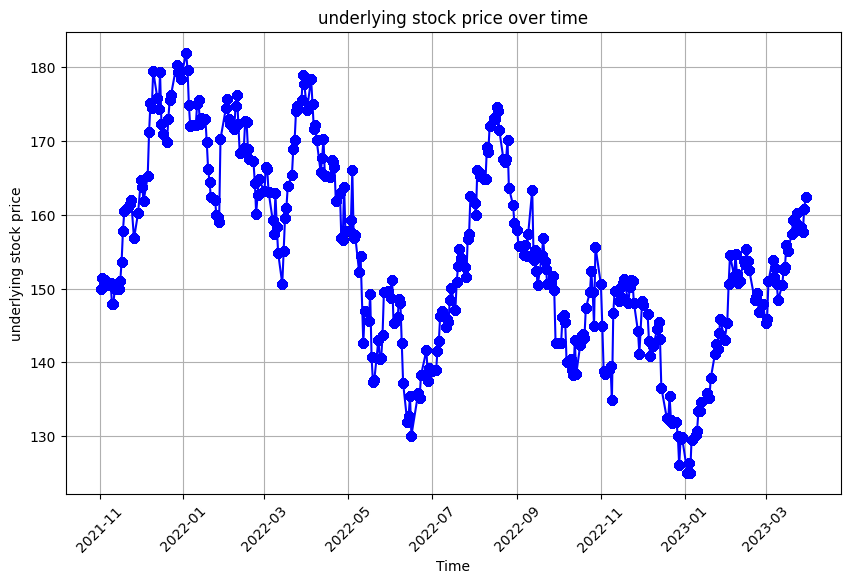

In [16]:
import matplotlib.pyplot as plt

# Plotting the underlying stock price over time
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['underlying_stockprice'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('underlying stock price')
plt.title('underlying stock price over time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


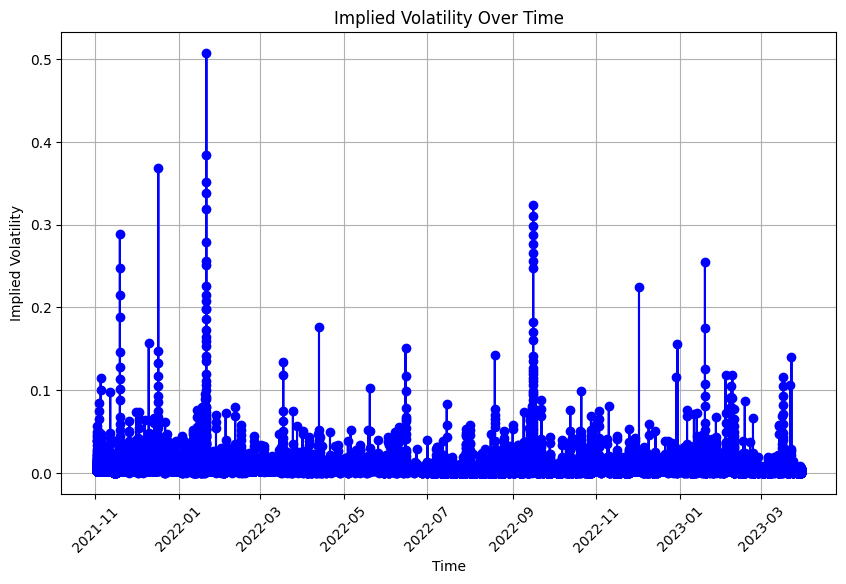

In [17]:
import matplotlib.pyplot as plt

# Plotting the Implied Volatility over time
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['IV'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


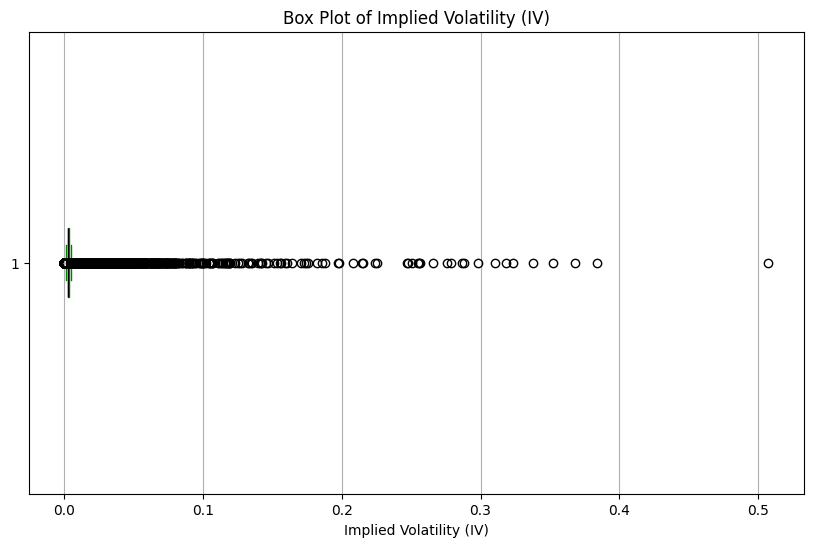

In [18]:
# Plotting a box plot for Implied Volatility (IV) to show its distribution
plt.figure(figsize=(10, 6))
plt.boxplot(data['IV'], vert=False, patch_artist=True, boxprops=dict(facecolor='g', color='g'), whiskerprops=dict(color='g'), capprops=dict(color='g'), medianprops=dict(color='black'))
plt.xlabel('Implied Volatility (IV)')
plt.title('Box Plot of Implied Volatility (IV)')
plt.grid(True, axis='x')
plt.show()


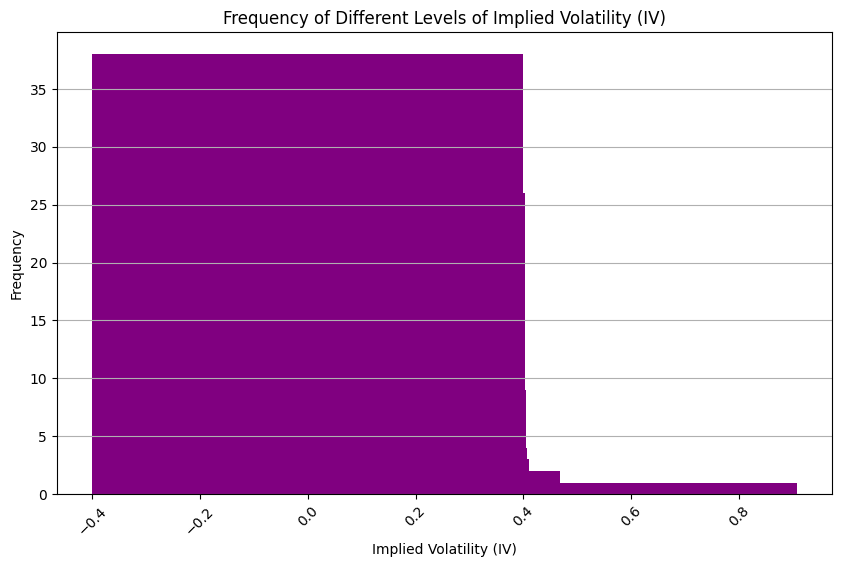

In [19]:
# Plotting a bar chart to show the frequency of different levels of Implied Volatility (IV)
plt.figure(figsize=(10, 6))
iv_counts = data['IV'].value_counts().sort_index()
plt.bar(iv_counts.index, iv_counts.values, color='purple')
plt.xlabel('Implied Volatility (IV)')
plt.ylabel('Frequency')
plt.title('Frequency of Different Levels of Implied Volatility (IV)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


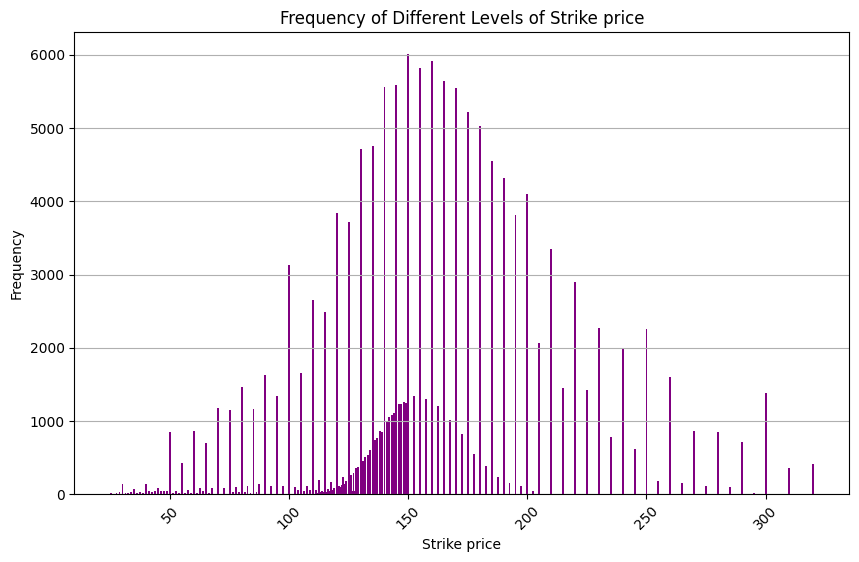

In [20]:
# Plotting a bar chart to show the frequency of different levels of Strike price
plt.figure(figsize=(10, 6))
strike_counts = data['Strike'].value_counts().sort_index()
plt.bar(strike_counts.index, strike_counts.values, color='purple')
plt.xlabel('Strike price')
plt.ylabel('Frequency')
plt.title('Frequency of Different Levels of Strike price')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


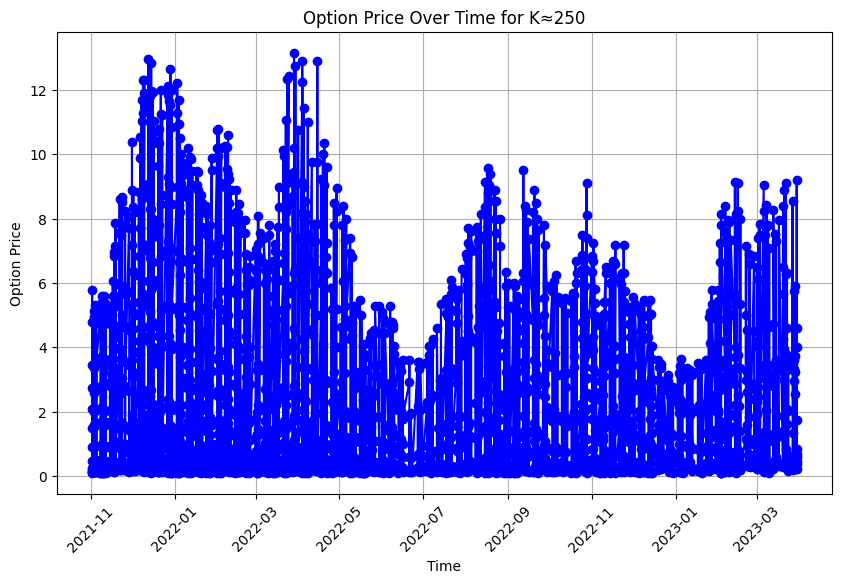

In [21]:
# Plotting Option Price Over Time for a specific strike price (K=250)
# Filter data for strike price closest to 250
if 'Strike' in data.columns:
    # Find strike prices close to 250
    strike_250_data = data[data['Strike'].between(245, 255)].copy()
    
    if len(strike_250_data) > 0:
        # Sort by Time for proper plotting
        strike_250_data = strike_250_data.sort_values(by='Time')
        
        plt.figure(figsize=(10, 6))
        plt.plot(strike_250_data['Time'], strike_250_data['option_price'], marker='o', linestyle='-', color='b')
        plt.xlabel('Time')
        plt.ylabel('Option Price')
        plt.title('Option Price Over Time for K≈250')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    else:
        print("No data found for strike prices around 250")
else:
    print("Strike column not found in data")


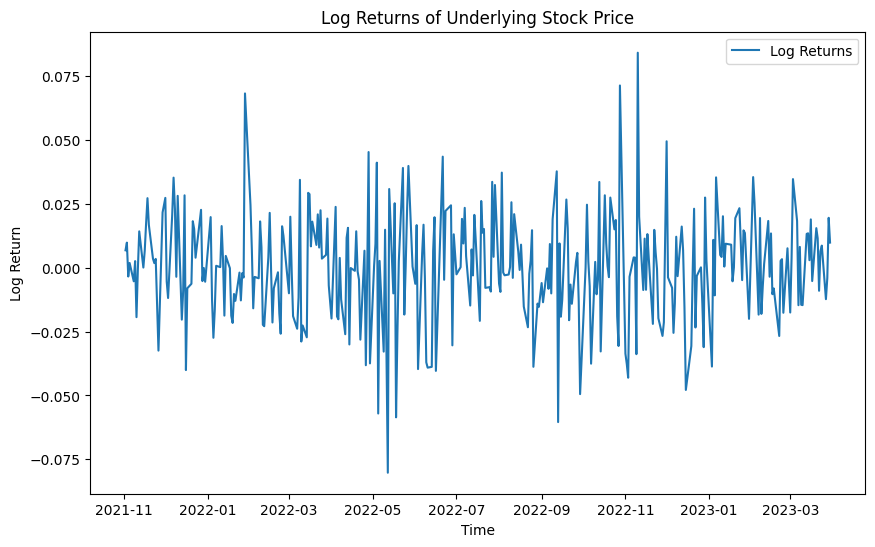

⚠ GARCH library (arch) not installed - using IV as cond_vol
Install with: pip install arch


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate log returns of the underlying stock prices (if not already calculated)
# Use the same corrected logic as Cell 9 to handle multiple rows per date
if 'log_return' not in data.columns:
    # Get unique dates and their stock prices
    unique_dates = data[['Time', 'underlying_stockprice']].drop_duplicates(subset=['Time'])
    unique_dates = unique_dates.sort_values(by='Time').reset_index(drop=True)
    
    # Calculate log returns on unique dates
    unique_dates['log_return'] = np.log(unique_dates['underlying_stockprice'] / unique_dates['underlying_stockprice'].shift(1))
    
    # Merge log returns back to original dataframe
    data = data.merge(unique_dates[['Time', 'log_return']], on='Time', how='left', suffixes=('', '_daily'))
    
    # Drop the old log_return column if it exists and rename the new one
    if 'log_return' in data.columns and 'log_return_daily' in data.columns:
        data = data.drop(columns=['log_return'])
        data = data.rename(columns={'log_return_daily': 'log_return'})
    elif 'log_return_daily' in data.columns:
        data = data.rename(columns={'log_return_daily': 'log_return'})
    
    # Drop rows where log_return is NaN (first row of each date group)
    data = data.dropna(subset=['log_return'])

# Plot the log returns
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['log_return'], label='Log Returns')
plt.title('Log Returns of Underlying Stock Price')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

# Fit a GARCH(1,1) model
try:
    from arch import arch_model
    # Use unique log returns for GARCH fitting (one per day) if available
    if 'unique_dates' in locals():
        unique_returns = unique_dates['log_return'].dropna().values
    else:
        # Fallback: get unique returns from data
        unique_dates_viz = data[['Time', 'log_return']].drop_duplicates(subset=['Time'])
        unique_returns = unique_dates_viz['log_return'].dropna().values
    
    model = arch_model(unique_returns, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp='off')
    
    # Create conditional volatility dataframe and merge back
    if 'unique_dates' in locals():
        cond_vol_df = pd.DataFrame({
            'Time': unique_dates['Time'].values,
            'cond_vol': garch_fit.conditional_volatility
        })
    else:
        cond_vol_df = pd.DataFrame({
            'Time': unique_dates_viz['Time'].values,
            'cond_vol': garch_fit.conditional_volatility
        })
    data = data.merge(cond_vol_df, on='Time', how='left')
    
    # Summarize the GARCH model fit
    print(garch_fit.summary())
    
except ImportError:
    print("⚠ GARCH library (arch) not installed - using IV as cond_vol")
    print("Install with: pip install arch")
    if 'cond_vol' not in data.columns:
        data['cond_vol'] = data['IV']
except Exception as e:
    print(f"⚠ GARCH model fitting error: {e}")
    print("Using IV as cond_vol")
    if 'cond_vol' not in data.columns:
        data['cond_vol'] = data['IV']


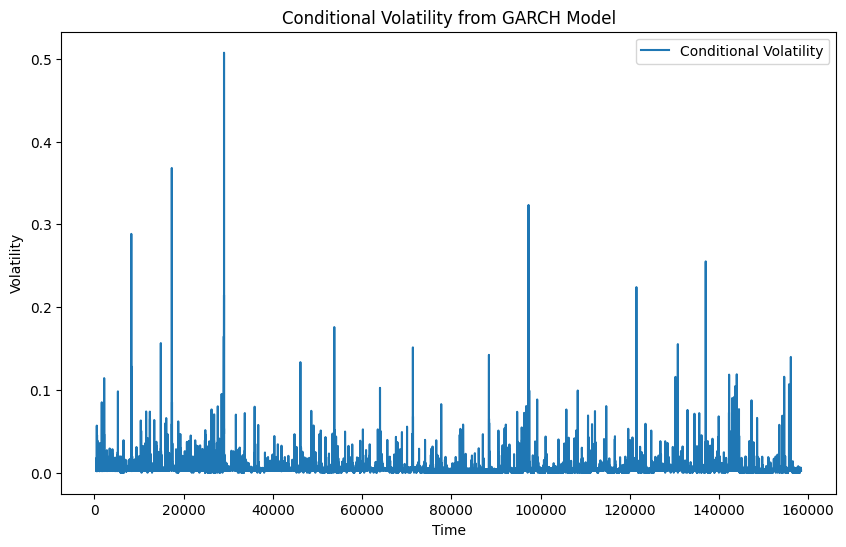

In [23]:
# Plot the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(data['cond_vol'], label='Conditional Volatility')
plt.title('Conditional Volatility from GARCH Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


## Machine Learning Models for Option Pricing

In this section, we implement three neural network architectures (MLP, LSTM, GRU) to predict option prices. We'll train models both with and without GARCH conditional volatility features to compare their performance.

### Overview
- **Target Variable**: `C/S` (Call option price / Stock price) - normalized for scale independence
- **Features**: `IV` (Implied Volatility), `K/S` (Strike/Stock ratio), `Maturity` (time to expiration), `r` (risk-free rate)
- **Optional Feature**: `cond_vol` (GARCH conditional volatility) - when available
- **Models**: MLP (Multi-Layer Perceptron), LSTM (Long Short-Term Memory), GRU (Gated Recurrent Unit)

In [24]:
# Check data availability and columns
print(f"Data shape: {data.shape}")
print(f"\nAvailable columns:")
print(data.columns.tolist())
print(f"\nFirst few rows:")
data.head()

Data shape: (157919, 35)

Available columns:
['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'Time', 'QUOTE_TIME_HOURS', 'underlying_stockprice', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'IV', 'option_price', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'YearMonth', 'Strike', 'Volume', 'r', 'Maturity', 'C/S', 'Monyness', 'K/S', 'log_return', 'cond_vol']

First few rows:


QUOTE_UNIXTIME     QUOTE_READTIME       Time  QUOTE_TIME_HOURS  \
480      1635883200   2021-11-02 16:00 2021-11-02              16.0   
481      1635883200   2021-11-02 16:00 2021-11-02              16.0   
482      1635883200   2021-11-02 16:00 2021-11-02              16.0   
483      1635883200   2021-11-02 16:00 2021-11-02              16.0   
484      1635883200   2021-11-02 16:00 2021-11-02              16.0   

     underlying_stockprice  EXPIRE_DATE  EXPIRE_UNIX    DTE  C_DELTA  C_GAMMA  \
480                  150.0   2021-11-26   1637960400  24.04  0.94473  0.00788   
481                  150.0   2021-11-26   1637960400  24.04  0.94388  0.00898   
482                  150.0   2021-11-26   1637960400  24.04  0.92275  0.00035   
483                  150.0   2021-11-26   1637960400  24.04  0.92926  0.00046   
484                  150.0   2021-11-26   1637960400  24.04  0.93410  0.00070   

     ...  YearMonth  Strike  Volume       r  Maturity       C/S  Monyness  \
480  ...    2021-11   134.0     3.0  0.0516  0.111111  0.111667  1.119403   
481  ...    2021-11   135.0     4.0  0.0516  0.111111  0.107133  1.111111   
482  ...    2021-11   105.0     1.0  0.0516  0.111111  0.297933  1.428571   
483  ...    2021-11   110.0    21.0  0.0516  0.111111  0.262667  1.363636   
484  ...    2021-11   115.0    11.0  0.0516  0.111111  0.229333  1.304348   

          K/S  log_return  cond_vol  
480  0.893333    0.006823  0.002719  
481  0.900000    0.006823  0.002564  
482  0.700000    0.006823  0.008363  
483  0.733333    0.006823  0.007110  
484  0.766667    0.006823  0.005975  

[5 rows x 35 columns]

### Step 1: Feature Selection and Target Definition

We define our features and target variable. The target `C/S` represents the normalized option price, making it scale-independent and suitable for cross-asset comparison.


In [25]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time
import warnings
import os
warnings.filterwarnings('ignore')

# Check if cond_vol is available (from GARCH model)
use_garch = 'cond_vol' in data.columns and data['cond_vol'].notna().sum() > 0

# Define feature columns
if use_garch:
    feature_columns = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
    print("✓ Using GARCH conditional volatility as additional feature")
else:
    feature_columns = ['IV', 'K/S', 'Maturity', 'r']
    print("⚠ GARCH not available - using IV only")

# Define target columns
target_column_cs = 'C/S'
target_column_log_cs = 'log_C_S'

# Add log_C_S if not already present
if target_column_log_cs not in data.columns:
    data['log_C_S'] = np.log(data['C/S'])

print(f"\nFeatures: {feature_columns}")
print(f"Targets: {target_column_cs} and {target_column_log_cs}")

# Check for missing values
print(f"\nMissing values check:")
print(data[feature_columns + [target_column_cs, target_column_log_cs]].isnull().sum())

# Remove rows with missing values
data_clean = data[feature_columns + [target_column_cs, target_column_log_cs]].dropna()
print(f"\n✓ Clean data: {len(data_clean):,} rows (removed {len(data) - len(data_clean):,} rows with missing values)")


✓ Using GARCH conditional volatility as additional feature

Features: ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
Targets: C/S and log_C_S

Missing values check:
IV          0
K/S         0
Maturity    0
r           0
cond_vol    0
C/S         0
log_C_S     0
dtype: int64

✓ Clean data: 157,919 rows (removed 0 rows with missing values)


### Step 2: Train-Test Split

We split the data into training (80%) and testing (20%) sets using a random seed for reproducibility.


In [26]:
# Split the data into features and targets
X = data_clean[feature_columns]
y_cs = data_clean[target_column_cs]
y_log_cs = data_clean[target_column_log_cs]

# Split into training and testing sets (80/20 split) - same split for both targets
X_train, X_test, y_train_cs, y_test_cs = train_test_split(
    X, y_cs, 
    test_size=0.2, 
    random_state=42
)

# Use same indices for log(C/S) target
train_indices = y_train_cs.index
test_indices = y_test_cs.index
y_train_log_cs = y_log_cs.loc[train_indices]
y_test_log_cs = y_log_cs.loc[test_indices]

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(data_clean)*100:.1f}%)")
print(f"Testing set: {len(X_test):,} samples ({len(X_test)/len(data_clean)*100:.1f}%)")
print(f"\nTarget statistics (C/S):")
print(f"  Training - Mean: {y_train_cs.mean():.6f}, Std: {y_train_cs.std():.6f}")
print(f"  Testing  - Mean: {y_test_cs.mean():.6f}, Std: {y_test_cs.std():.6f}")
print(f"\nTarget statistics (log(C/S)):")
print(f"  Training - Mean: {y_train_log_cs.mean():.6f}, Std: {y_train_log_cs.std():.6f}")
print(f"  Testing  - Mean: {y_test_log_cs.mean():.6f}, Std: {y_test_log_cs.std():.6f}")


Training set: 126,335 samples (80.0%)
Testing set: 31,584 samples (20.0%)

Target statistics (C/S):
  Training - Mean: 0.131874, Std: 0.157472
  Testing  - Mean: 0.131923, Std: 0.157461

Target statistics (log(C/S)):
  Training - Mean: -3.005521, Std: 1.728738
  Testing  - Mean: -3.007566, Std: 1.732607


### Step 3: Data Scaling

We standardize the features using StandardScaler to ensure all features are on a similar scale, which helps neural networks converge faster and perform better.


In [27]:
# Scale the features for both targets (same features, different targets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")
print(f"  Scaled training shape: {X_train_scaled.shape}")
print(f"  Scaled testing shape: {X_test_scaled.shape}")

# Reshape data for LSTM (requires 3D: samples, timesteps, features)
# For time series, we use 1 timestep per sample
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"\n✓ Reshaped for LSTM:")
print(f"  LSTM training shape: {X_train_lstm.shape}")
print(f"  LSTM testing shape: {X_test_lstm.shape}")

# Get input dimension for model creation
input_dim = X_train_scaled.shape[1]
print(f"\n✓ Input dimension: {input_dim} features")


✓ Features scaled using StandardScaler
  Scaled training shape: (126335, 5)
  Scaled testing shape: (31584, 5)

✓ Reshaped for LSTM:
  LSTM training shape: (126335, 1, 5)
  LSTM testing shape: (31584, 1, 5)

✓ Input dimension: 5 features


### Step 4: Model Architecture Definitions

We define three neural network architectures:
1. **MLP**: Feedforward network with dense layers
2. **LSTM**: Long Short-Term Memory network for sequential patterns
3. **GRU**: Gated Recurrent Unit, similar to LSTM but computationally more efficient


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Get input dimension
input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim} features")

def create_mlp_model(input_dim=input_dim):
    """Create Multi-Layer Perceptron (MLP) model"""
    model = Sequential([
        Dense(units=100, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(units=50, activation='relu'),
        Dropout(0.2),
        Dense(units=25, activation='relu'),
        Dense(units=1)  # Output layer
    ])
    # Use legacy optimizer for M1/M2 Mac compatibility
    try:
        from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
        model.compile(optimizer=LegacyAdam(learning_rate=0.001), loss='mean_squared_error')
    except ImportError:
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def create_lstm_model(input_dim=input_dim):
    """Create LSTM model"""
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=(1, input_dim)),
        LSTM(units=100, return_sequences=False),
        Dropout(0.3),
        Dense(units=50, activation='elu'),
        Dense(units=1)
    ])
    # Use legacy optimizer for M1/M2 Mac compatibility
    try:
        from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
        model.compile(optimizer=LegacyAdam(learning_rate=0.001), loss='mean_squared_error')
    except ImportError:
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

print("✓ Model architectures defined (MLP and LSTM only - GRU removed)")


Input dimension: 5 features
✓ Model architectures defined (MLP and LSTM only - GRU removed)


---

## Model Training: Complete Structure (8 Unique Models)

We train **exactly 8 unique models** following the dissertation notebook structure:

### Training Structure:
**4 Models WITH GARCH features:**
1. MLP with GARCH on C/S
2. MLP with GARCH on log(C/S)
3. LSTM with GARCH on C/S
4. LSTM with GARCH on log(C/S)

**4 Models WITHOUT GARCH features:**
5. MLP without GARCH on C/S
6. MLP without GARCH on log(C/S)
7. LSTM without GARCH on C/S
8. LSTM without GARCH on log(C/S)

### Optimal Hyperparameters (from testing):
- **MLP**: Leaky ReLU activation, epochs=150, batch_size=40, neurons=[30, 60, 90]
- **LSTM**: ELU activation, epochs=150, batch_size=16, units=100, dropout=0.2
- **Loss Function**: mean_squared_error
- **Optimizer**: Adam(learning_rate=0.001)

### Model Saving:
All models are saved in the `models/` folder with descriptive names:
- `mlp_cs_with_garch.h5`
- `mlp_cs_without_garch.h5`
- `mlp_log_cs_with_garch.h5`
- `mlp_log_cs_without_garch.h5`
- `lstm_cs_with_garch.h5`
- `lstm_cs_without_garch.h5`
- `lstm_log_cs_with_garch.h5`
- `lstm_log_cs_without_garch.h5`


In [29]:
# Import LeakyReLU for optimal MLP
from keras.layers import LeakyReLU
from keras.activations import elu

# Optimal hyperparameters from testing
OPTIMAL_EPOCHS_MLP = 150
OPTIMAL_BATCH_SIZE_MLP = 40
OPTIMAL_EPOCHS_LSTM = 150
OPTIMAL_BATCH_SIZE_LSTM = 16

# Create directory for saving models
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
print(f"✓ Created/verified model directory: {model_dir}/")

print("=" * 80)
print("OPTIMAL HYPERPARAMETERS (from OptionPricingMLTests.ipynb)")
print("=" * 80)
print(f"MLP:  Epochs={OPTIMAL_EPOCHS_MLP}, Batch Size={OPTIMAL_BATCH_SIZE_MLP}, Activation=LeakyReLU")
print(f"LSTM: Epochs={OPTIMAL_EPOCHS_LSTM}, Batch Size={OPTIMAL_BATCH_SIZE_LSTM}, Activation=ELU")
print("=" * 80)
print("Training exactly 8 unique models: MLP/LSTM × C/S/log(C/S) × with/without GARCH")
print("=" * 80)


✓ Created/verified model directory: models/
OPTIMAL HYPERPARAMETERS (from OptionPricingMLTests.ipynb)
MLP:  Epochs=150, Batch Size=40, Activation=LeakyReLU
LSTM: Epochs=150, Batch Size=16, Activation=ELU
Training exactly 8 unique models: MLP/LSTM × C/S/log(C/S) × with/without GARCH


### Step 9: Model Architectures

We define models that will be trained on both C/S and log(C/S) targets, with and without GARCH features.


In [30]:
def create_mlp_model(input_dim):
    """Create optimized MLP model with LeakyReLU (best from testing)"""
    model = Sequential([
        Dense(units=30, input_dim=input_dim),
        LeakyReLU(),
        Dense(units=60),
        LeakyReLU(),
        Dense(units=90),
        LeakyReLU(),
        Dense(units=1)  # Output layer
    ])
    # Use legacy optimizer for M1/M2 Mac compatibility
    try:
        from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
        model.compile(optimizer=LegacyAdam(learning_rate=0.001), loss='mean_squared_error')
    except ImportError:
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def create_lstm_model(input_dim):
    """Create optimized LSTM model (matching dissertation)"""
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=(1, input_dim)),
        LSTM(units=100, return_sequences=False),
        Dropout(0.2),
        Dense(units=50, activation='elu'),
        Dense(units=1)
    ])
    # Use legacy optimizer for M1/M2 Mac compatibility
    try:
        from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
        model.compile(optimizer=LegacyAdam(learning_rate=0.001), loss='mean_squared_error')
    except ImportError:
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

print("✓ Model architectures defined (MLP and LSTM only)")


✓ Model architectures defined (MLP and LSTM only)


In [31]:
# Load data if not already loaded
# Check if data variable exists in the current namespace
if 'data' not in globals() or data is None:
    # Try to load from combine.csv if exists
    try:
        data = pd.read_csv('combine.csv')
        data['Time'] = pd.to_datetime(data['Time'])
        print(f"✓ Loaded data from combine.csv: {len(data):,} rows")
    except FileNotFoundError:
        print("⚠ ERROR: Data not found!")
        print("  Please run the data preparation cells first (cells that create 'data' variable)")
        print("  OR ensure 'combine.csv' exists in the current directory")
        raise NameError("'data' variable not found. Please run data preparation cells first.")
else:
    print(f"✓ Using existing data variable: {len(data):,} rows")

# Ensure log_C_S column exists
if 'log_C_S' not in data.columns:
    data['log_C_S'] = np.log(data['C/S'])
    print(f"✓ Created log_C_S column")

# Verify required columns exist
required_cols = ['IV', 'K/S', 'Maturity', 'r', 'C/S', 'log_C_S']
missing_cols = [col for col in required_cols if col not in data.columns]
if missing_cols:
    print(f"⚠ WARNING: Missing required columns: {missing_cols}")
    print(f"  Available columns: {data.columns.tolist()}")
else:
    print(f"✓ All required columns present")

print(f"\n✓ Data ready: {len(data):,} rows, {len(data.columns)} columns")


✓ Using existing data variable: 157,919 rows
✓ All required columns present

✓ Data ready: 157,919 rows, 36 columns


---

## Section 1: Models WITHOUT GARCH Features

In this section, we train models using only the base features: `IV`, `K/S`, `Maturity`, and `r` (without GARCH conditional volatility).

We'll train:
1. MLP on C/S
2. MLP on log(C/S)
3. LSTM on C/S
4. LSTM on log(C/S)

Each model will be evaluated with metrics and visualizations.


In [32]:
# ============================================================================
# SECTION 1: WITHOUT GARCH
# ============================================================================

# Verify data is available
if 'data' not in globals() or data is None:
    raise NameError("'data' variable not found. Please run the data loading cell (cell 38) first!")

# Verify OPTIMAL constants are defined
if 'OPTIMAL_EPOCHS_MLP' not in globals() or 'OPTIMAL_BATCH_SIZE_MLP' not in globals():
    raise NameError("OPTIMAL constants not found. Please run cell 35 (hyperparameters cell) first!")

# Verify model functions are defined
if 'create_mlp_model' not in globals() or 'create_lstm_model' not in globals():
    raise NameError("Model functions not found. Please run cell 37 (model definitions) first!")

# Feature columns WITHOUT GARCH
feature_columns_no_garch = ['IV', 'K/S', 'Maturity', 'r']
target_column_cs = 'C/S'
target_column_log_cs = 'log_C_S'

print("=" * 80)
print("SECTION 1: TRAINING MODELS WITHOUT GARCH FEATURES")
print("=" * 80)
print(f"Features: {feature_columns_no_garch}")
print(f"Targets: {target_column_cs} and {target_column_log_cs}")
print("=" * 80)

# Verify all required columns exist
required_cols = feature_columns_no_garch + [target_column_cs, target_column_log_cs]
missing_cols = [col for col in required_cols if col not in data.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}. Available columns: {data.columns.tolist()}")

# Prepare data without GARCH
data_no_garch = data[required_cols].dropna()
print(f"\n✓ Clean data (no GARCH): {len(data_no_garch):,} rows")
if len(data_no_garch) == 0:
    raise ValueError("No data available after cleaning! Check for missing values.")


SECTION 1: TRAINING MODELS WITHOUT GARCH FEATURES
Features: ['IV', 'K/S', 'Maturity', 'r']
Targets: C/S and log_C_S

✓ Clean data (no GARCH): 157,919 rows


### 1.1 MLP Model on C/S (Without GARCH)


In [33]:
# MLP on C/S without GARCH
print("\n" + "=" * 80)
print("1.1 MLP Model on C/S (Without GARCH)")
print("=" * 80)

# Prepare features and target
X_no_garch = data_no_garch[feature_columns_no_garch]
y_cs_no_garch = data_no_garch[target_column_cs]

# Train-test split
X_train_no_garch, X_test_no_garch, y_train_cs_no_garch, y_test_cs_no_garch = train_test_split(
    X_no_garch, y_cs_no_garch, test_size=0.2, random_state=42
)

# Scale features
scaler_no_garch = StandardScaler()
X_train_scaled_no_garch = scaler_no_garch.fit_transform(X_train_no_garch)
X_test_scaled_no_garch = scaler_no_garch.transform(X_test_no_garch)

# Create and train MLP model
input_dim_no_garch = X_train_scaled_no_garch.shape[1]
mlp_model_cs_no_garch = create_mlp_model(input_dim_no_garch)

print(f"Training MLP on C/S (no GARCH)...")
mlp_start_time = time.time()
mlp_history_cs_no_garch = mlp_model_cs_no_garch.fit(
    X_train_scaled_no_garch, y_train_cs_no_garch,
    epochs=OPTIMAL_EPOCHS_MLP,
    batch_size=OPTIMAL_BATCH_SIZE_MLP,
    verbose=0,
    validation_split=0.1
)
mlp_training_time = time.time() - mlp_start_time

# Predictions
y_pred_mlp_cs_no_garch = mlp_model_cs_no_garch.predict(X_test_scaled_no_garch, verbose=0).flatten()

# Metrics
rmse_mlp_cs_no_garch = np.sqrt(mean_squared_error(y_test_cs_no_garch, y_pred_mlp_cs_no_garch))
mae_mlp_cs_no_garch = mean_absolute_error(y_test_cs_no_garch, y_pred_mlp_cs_no_garch)
mse_mlp_cs_no_garch = mean_squared_error(y_test_cs_no_garch, y_pred_mlp_cs_no_garch)
r2_mlp_cs_no_garch = r2_score(y_test_cs_no_garch, y_pred_mlp_cs_no_garch)

print(f"\n✓ Training completed in {mlp_training_time:.2f} seconds")
print(f"  RMSE: {rmse_mlp_cs_no_garch:.10f}")
print(f"  MAE:  {mae_mlp_cs_no_garch:.10f}")
print(f"  MSE:  {mse_mlp_cs_no_garch:.10f}")
print(f"  R²:   {r2_mlp_cs_no_garch:.6f}")

# Save model
mlp_model_cs_no_garch.save('models/mlp_cs_without_garch.h5')
print(f"✓ Model saved: models/mlp_cs_without_garch.h5")



1.1 MLP Model on C/S (Without GARCH)
Training MLP on C/S (no GARCH)...

✓ Training completed in 172.87 seconds
  RMSE: 0.0363226824
  MAE:  0.0265962404
  MSE:  0.0013193373
  R²:   0.946786
✓ Model saved: models/mlp_cs_without_garch.h5


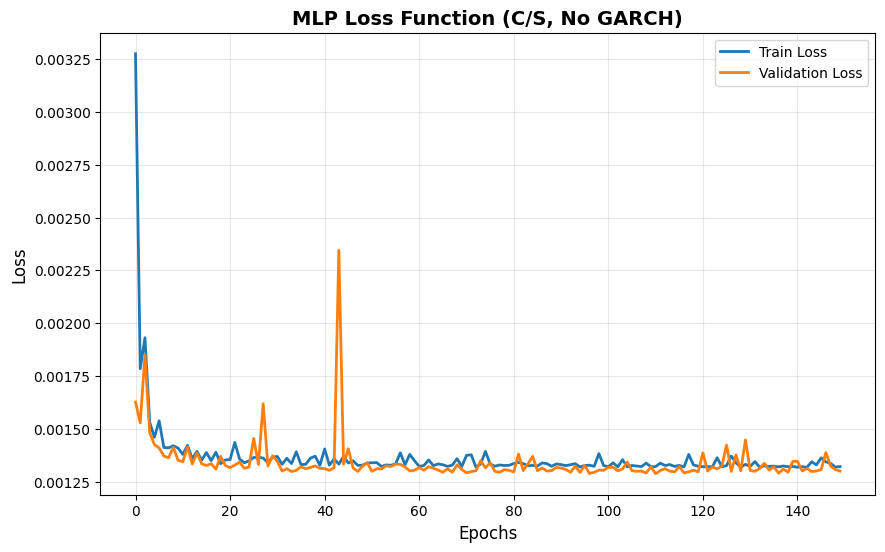

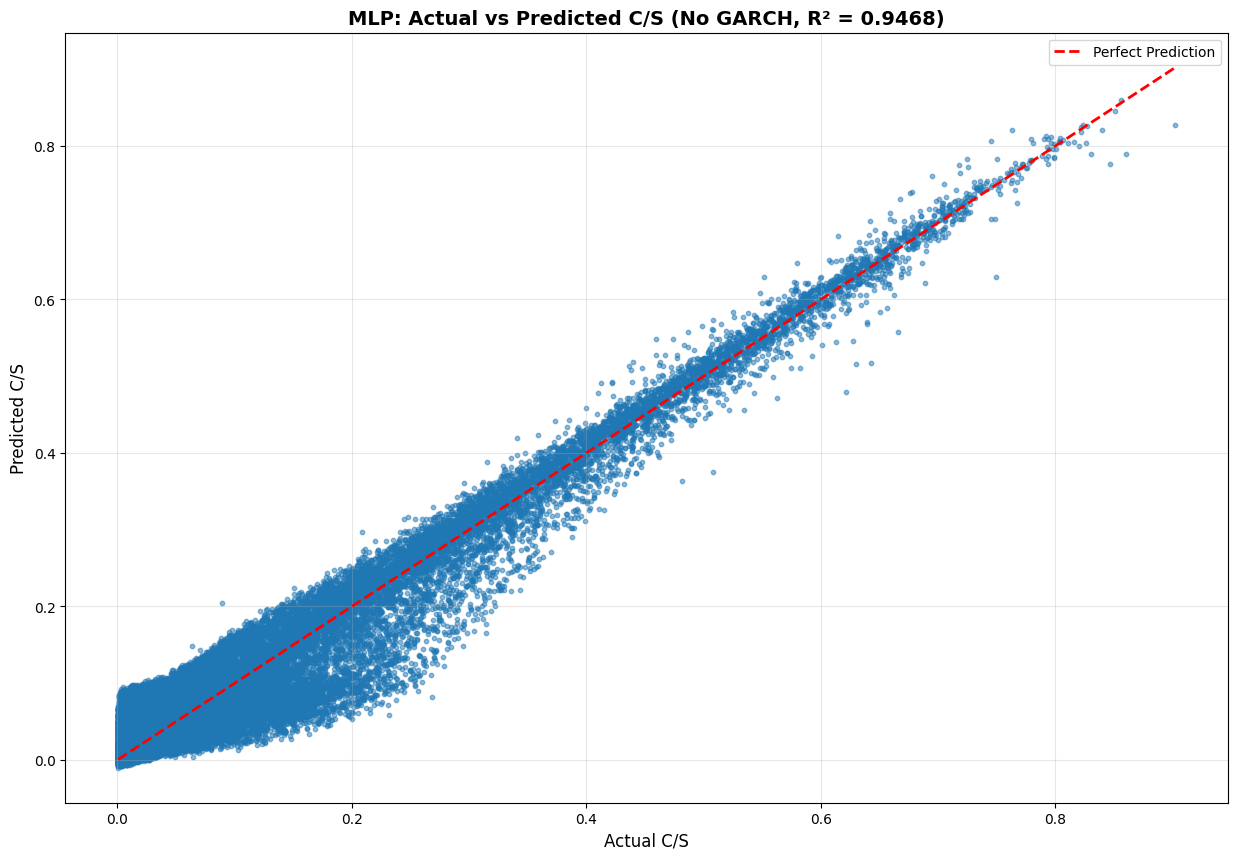


Fraction Error Statistics:
  Min:  -15.907673
  Max:  106.466552
  Mean: 1.892050
  Std:  7.149392


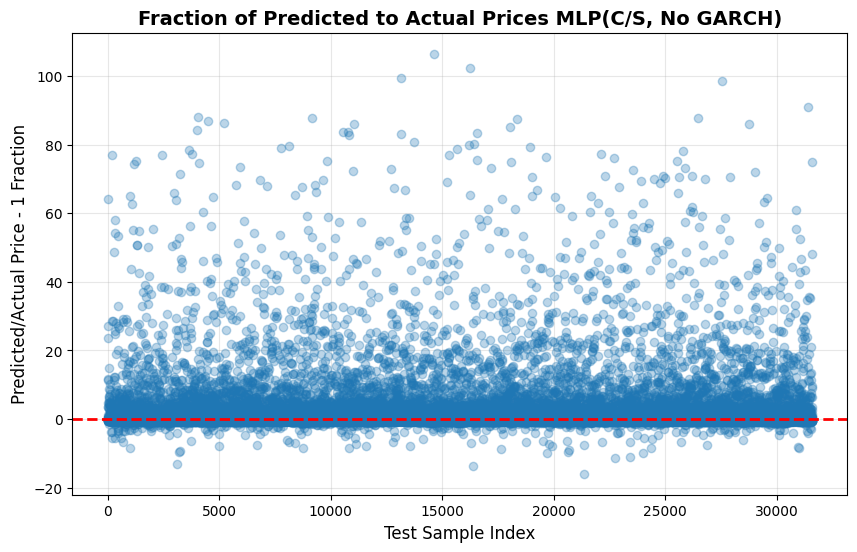

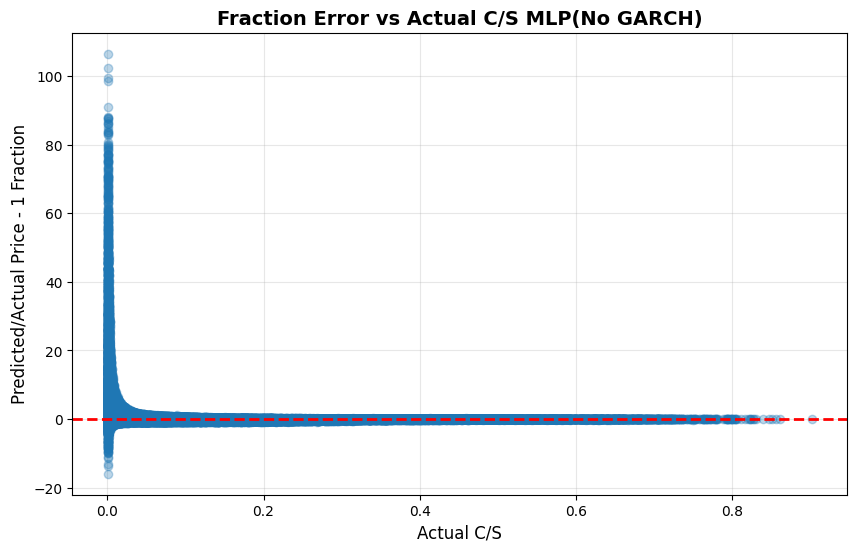

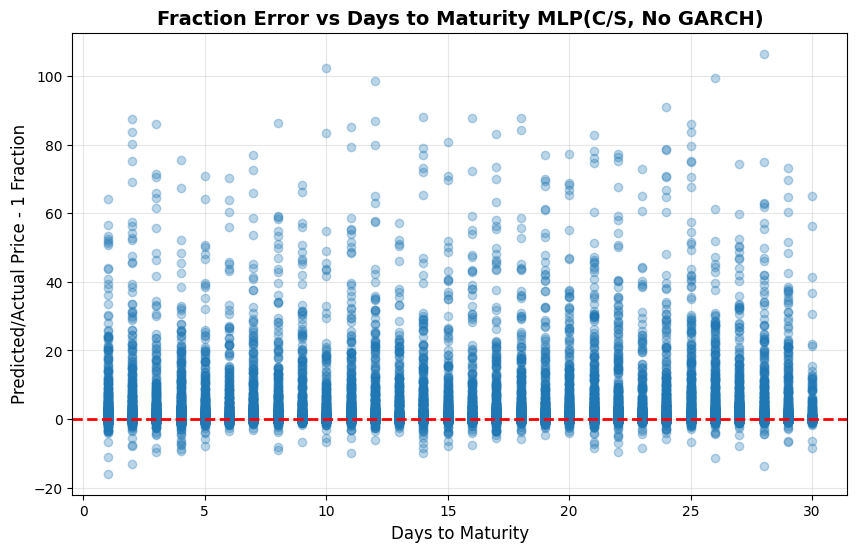

In [34]:
# Visualizations for MLP on C/S (no GARCH)
# 1. Loss curve
plt.figure(figsize=(10, 6))
plt.plot(mlp_history_cs_no_garch.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in mlp_history_cs_no_garch.history:
    plt.plot(mlp_history_cs_no_garch.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('MLP Loss Function (C/S, No GARCH)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Scatter plot: Actual vs Predicted
plt.figure(figsize=(15, 10))
plt.scatter(y_test_cs_no_garch, y_pred_mlp_cs_no_garch, alpha=0.5, s=10)
plt.plot([y_test_cs_no_garch.min(), y_test_cs_no_garch.max()], 
         [y_test_cs_no_garch.min(), y_test_cs_no_garch.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual C/S', fontsize=12)
plt.ylabel('Predicted C/S', fontsize=12)
plt.title(f'MLP: Actual vs Predicted C/S (No GARCH, R² = {r2_mlp_cs_no_garch:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Fraction error plot
y_test_reset = y_test_cs_no_garch.reset_index(drop=True)
fractions_mlp_cs_no_garch = (y_pred_mlp_cs_no_garch / y_test_reset.values) - 1

print("\nFraction Error Statistics:")
print(f"  Min:  {np.min(fractions_mlp_cs_no_garch):.6f}")
print(f"  Max:  {np.max(fractions_mlp_cs_no_garch):.6f}")
print(f"  Mean: {np.mean(fractions_mlp_cs_no_garch):.6f}")
print(f"  Std:  {np.std(fractions_mlp_cs_no_garch):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(fractions_mlp_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction of Predicted to Actual Prices MLP(C/S, No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Fraction error vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset.values, fractions_mlp_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Actual C/S', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Actual C/S MLP(No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 5. Fraction error vs Days to Maturity
maturity_test_no_garch = X_test_no_garch['Maturity'].values * 252
plt.figure(figsize=(10, 6))
plt.plot(maturity_test_no_garch, fractions_mlp_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Days to Maturity MLP(C/S, No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()


### 1.2 MLP Model on log(C/S) (Without GARCH)


In [35]:
# MLP on log(C/S) without GARCH
print("\n" + "=" * 80)
print("1.2 MLP Model on log(C/S) (Without GARCH)")
print("=" * 80)

# Prepare target
y_log_cs_no_garch = data_no_garch[target_column_log_cs]

# Train-test split (use same indices as C/S)
X_train_log_no_garch, X_test_log_no_garch, y_train_log_cs_no_garch, y_test_log_cs_no_garch = train_test_split(
    X_no_garch, y_log_cs_no_garch, test_size=0.2, random_state=42
)

# Scale features (use same scaler as C/S model)
X_train_scaled_log_no_garch = scaler_no_garch.fit_transform(X_train_log_no_garch)
X_test_scaled_log_no_garch = scaler_no_garch.transform(X_test_log_no_garch)

# Create and train MLP model
mlp_model_log_cs_no_garch = create_mlp_model(input_dim_no_garch)

print(f"Training MLP on log(C/S) (no GARCH)...")
mlp_start_time = time.time()
mlp_history_log_cs_no_garch = mlp_model_log_cs_no_garch.fit(
    X_train_scaled_log_no_garch, y_train_log_cs_no_garch,
    epochs=OPTIMAL_EPOCHS_MLP,
    batch_size=OPTIMAL_BATCH_SIZE_MLP,
    verbose=0,
    validation_split=0.1
)
mlp_training_time = time.time() - mlp_start_time

# Predictions
y_pred_mlp_log_cs_no_garch = mlp_model_log_cs_no_garch.predict(X_test_scaled_log_no_garch, verbose=0).flatten()

# Metrics
rmse_mlp_log_cs_no_garch = np.sqrt(mean_squared_error(y_test_log_cs_no_garch, y_pred_mlp_log_cs_no_garch))
mae_mlp_log_cs_no_garch = mean_absolute_error(y_test_log_cs_no_garch, y_pred_mlp_log_cs_no_garch)
mse_mlp_log_cs_no_garch = mean_squared_error(y_test_log_cs_no_garch, y_pred_mlp_log_cs_no_garch)
r2_mlp_log_cs_no_garch = r2_score(y_test_log_cs_no_garch, y_pred_mlp_log_cs_no_garch)

print(f"\n✓ Training completed in {mlp_training_time:.2f} seconds")
print(f"  RMSE: {rmse_mlp_log_cs_no_garch:.10f}")
print(f"  MAE:  {mae_mlp_log_cs_no_garch:.10f}")
print(f"  MSE:  {mse_mlp_log_cs_no_garch:.10f}")
print(f"  R²:   {r2_mlp_log_cs_no_garch:.6f}")

# Save model
mlp_model_log_cs_no_garch.save('models/mlp_log_cs_without_garch.h5')
print(f"✓ Model saved: models/mlp_log_cs_without_garch.h5")



1.2 MLP Model on log(C/S) (Without GARCH)
Training MLP on log(C/S) (no GARCH)...

✓ Training completed in 174.19 seconds
  RMSE: 0.9238161316
  MAE:  0.6238973464
  MSE:  0.8534362449
  R²:   0.715695
✓ Model saved: models/mlp_log_cs_without_garch.h5


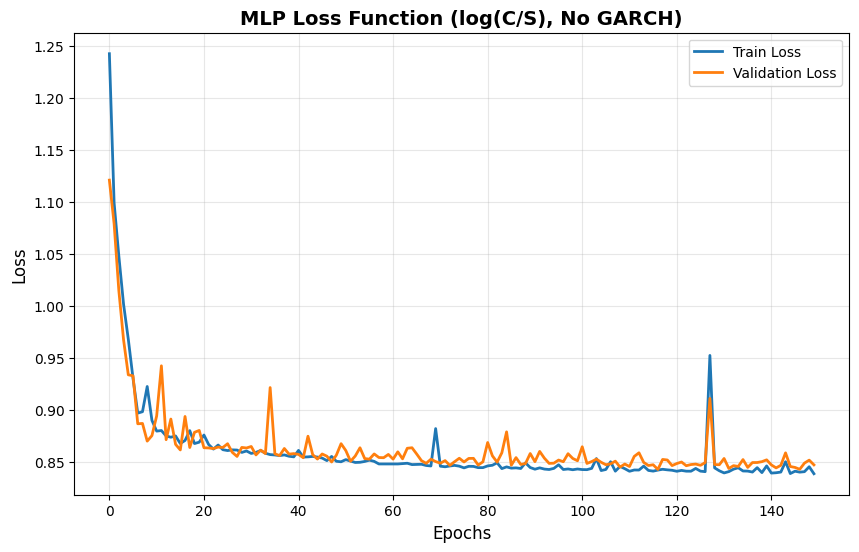

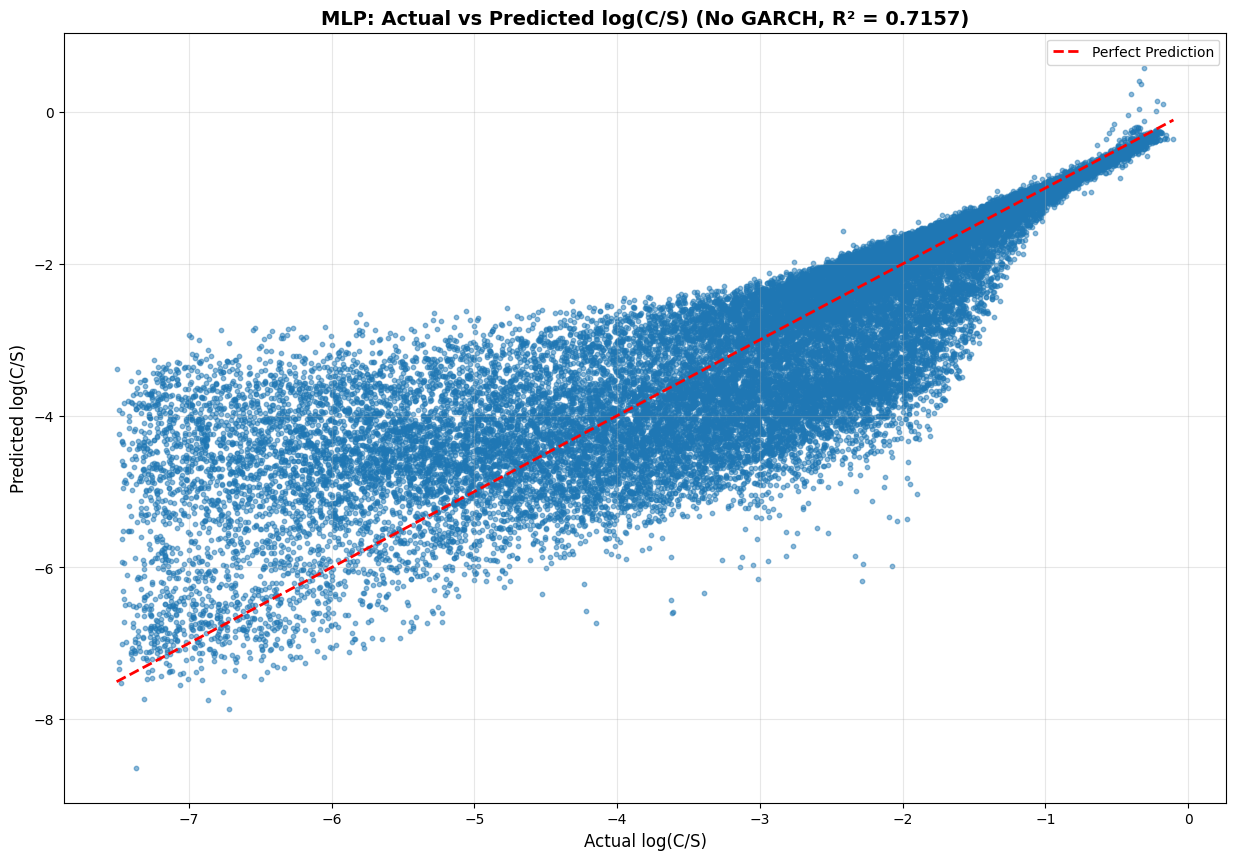


Fraction Error Statistics:
  Min:  -2.908114
  Max:  2.473692
  Mean: 0.061312
  Std:  0.271981


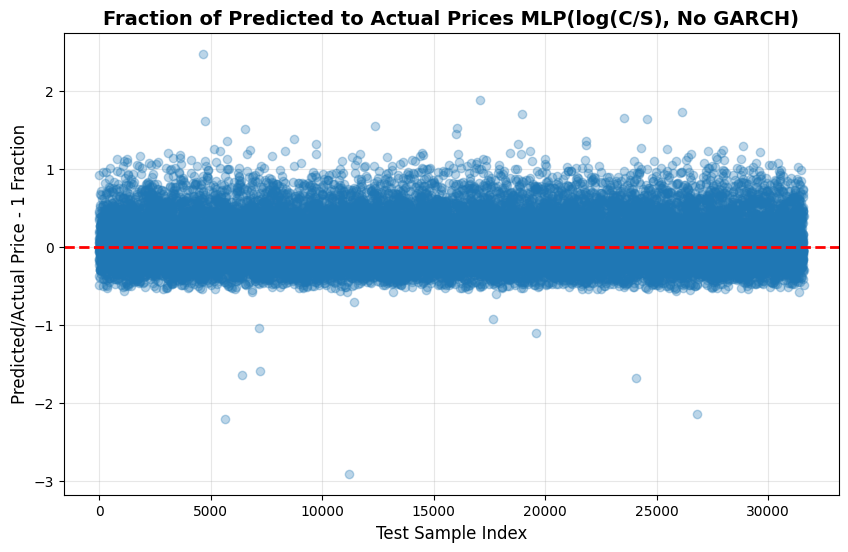

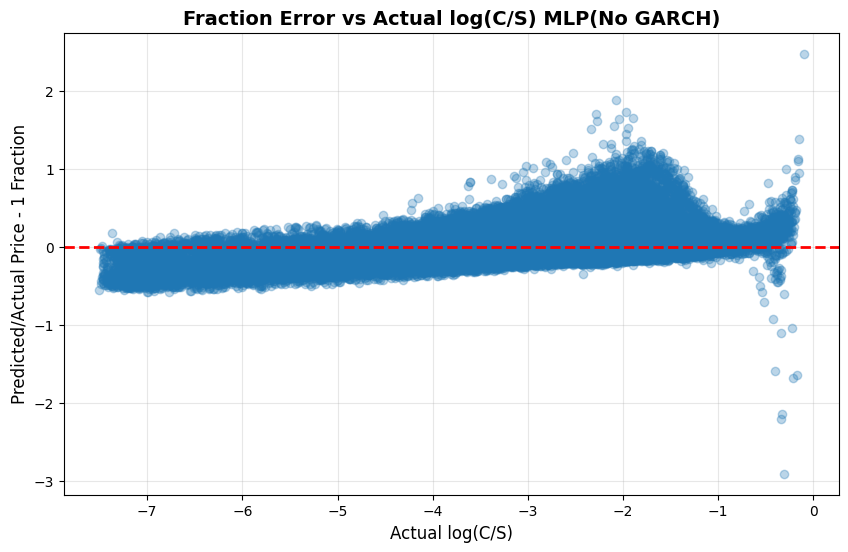

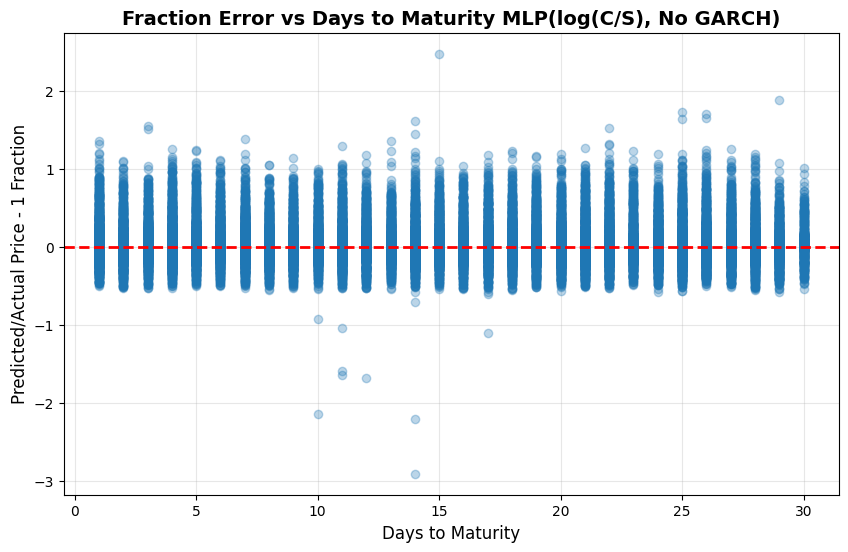

In [36]:
# Visualizations for MLP on log(C/S) (no GARCH)
# 1. Loss curve
plt.figure(figsize=(10, 6))
plt.plot(mlp_history_log_cs_no_garch.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in mlp_history_log_cs_no_garch.history:
    plt.plot(mlp_history_log_cs_no_garch.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('MLP Loss Function (log(C/S), No GARCH)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Scatter plot: Actual vs Predicted
plt.figure(figsize=(15, 10))
plt.scatter(y_test_log_cs_no_garch, y_pred_mlp_log_cs_no_garch, alpha=0.5, s=10)
plt.plot([y_test_log_cs_no_garch.min(), y_test_log_cs_no_garch.max()], 
         [y_test_log_cs_no_garch.min(), y_test_log_cs_no_garch.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual log(C/S)', fontsize=12)
plt.ylabel('Predicted log(C/S)', fontsize=12)
plt.title(f'MLP: Actual vs Predicted log(C/S) (No GARCH, R² = {r2_mlp_log_cs_no_garch:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Fraction error plot
y_test_log_reset = y_test_log_cs_no_garch.reset_index(drop=True)
fractions_mlp_log_cs_no_garch = (y_pred_mlp_log_cs_no_garch / y_test_log_reset.values) - 1

print("\nFraction Error Statistics:")
print(f"  Min:  {np.min(fractions_mlp_log_cs_no_garch):.6f}")
print(f"  Max:  {np.max(fractions_mlp_log_cs_no_garch):.6f}")
print(f"  Mean: {np.mean(fractions_mlp_log_cs_no_garch):.6f}")
print(f"  Std:  {np.std(fractions_mlp_log_cs_no_garch):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(fractions_mlp_log_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction of Predicted to Actual Prices MLP(log(C/S), No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Fraction error vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_log_reset.values, fractions_mlp_log_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Actual log(C/S)', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Actual log(C/S) MLP(No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 5. Fraction error vs Days to Maturity
maturity_test_log_no_garch = X_test_log_no_garch['Maturity'].values * 252
plt.figure(figsize=(10, 6))
plt.plot(maturity_test_log_no_garch, fractions_mlp_log_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Days to Maturity MLP(log(C/S), No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()


### 1.3 LSTM Model on C/S (Without GARCH)


In [37]:
# LSTM on C/S without GARCH
print("\n" + "=" * 80)
print("1.3 LSTM Model on C/S (Without GARCH)")
print("=" * 80)

# Reshape for LSTM (use same train-test split as MLP C/S)
X_train_lstm_no_garch = np.reshape(X_train_scaled_no_garch, (X_train_scaled_no_garch.shape[0], 1, X_train_scaled_no_garch.shape[1]))
X_test_lstm_no_garch = np.reshape(X_test_scaled_no_garch, (X_test_scaled_no_garch.shape[0], 1, X_test_scaled_no_garch.shape[1]))

# Create and train LSTM model
lstm_model_cs_no_garch = create_lstm_model(input_dim_no_garch)

print(f"Training LSTM on C/S (no GARCH)...")
lstm_start_time = time.time()
lstm_history_cs_no_garch = lstm_model_cs_no_garch.fit(
    X_train_lstm_no_garch, y_train_cs_no_garch,
    epochs=OPTIMAL_EPOCHS_LSTM,
    batch_size=OPTIMAL_BATCH_SIZE_LSTM,
    verbose=0,
    validation_split=0.1
)
lstm_training_time = time.time() - lstm_start_time

# Predictions
y_pred_lstm_cs_no_garch = lstm_model_cs_no_garch.predict(X_test_lstm_no_garch, verbose=0).flatten()

# Metrics
rmse_lstm_cs_no_garch = np.sqrt(mean_squared_error(y_test_cs_no_garch, y_pred_lstm_cs_no_garch))
mae_lstm_cs_no_garch = mean_absolute_error(y_test_cs_no_garch, y_pred_lstm_cs_no_garch)
mse_lstm_cs_no_garch = mean_squared_error(y_test_cs_no_garch, y_pred_lstm_cs_no_garch)
r2_lstm_cs_no_garch = r2_score(y_test_cs_no_garch, y_pred_lstm_cs_no_garch)

print(f"\n✓ Training completed in {lstm_training_time:.2f} seconds")
print(f"  RMSE: {rmse_lstm_cs_no_garch:.10f}")
print(f"  MAE:  {mae_lstm_cs_no_garch:.10f}")
print(f"  MSE:  {mse_lstm_cs_no_garch:.10f}")
print(f"  R²:   {r2_lstm_cs_no_garch:.6f}")

# Save model
lstm_model_cs_no_garch.save('models/lstm_cs_without_garch.h5')
print(f"✓ Model saved: models/lstm_cs_without_garch.h5")



1.3 LSTM Model on C/S (Without GARCH)
Training LSTM on C/S (no GARCH)...

✓ Training completed in 1190.34 seconds
  RMSE: 0.0359125893
  MAE:  0.0259414033
  MSE:  0.0012897141
  R²:   0.947981
✓ Model saved: models/lstm_cs_without_garch.h5


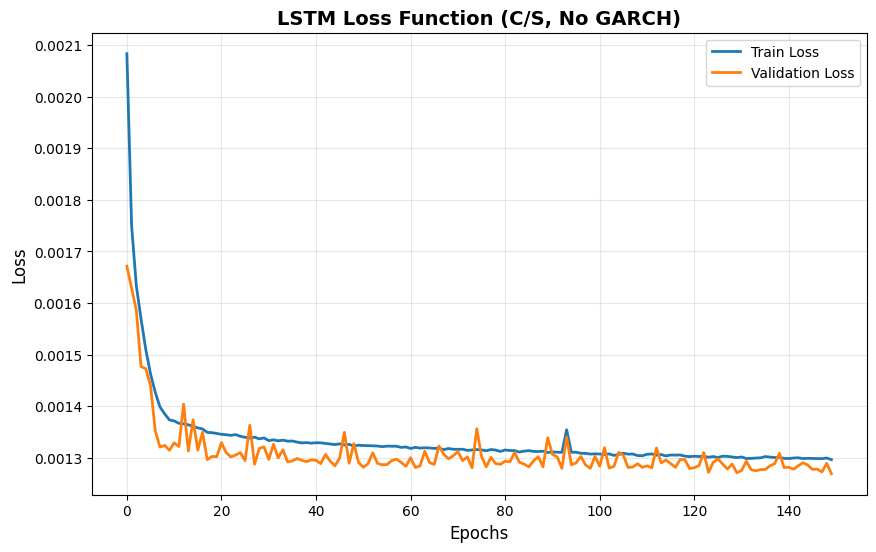

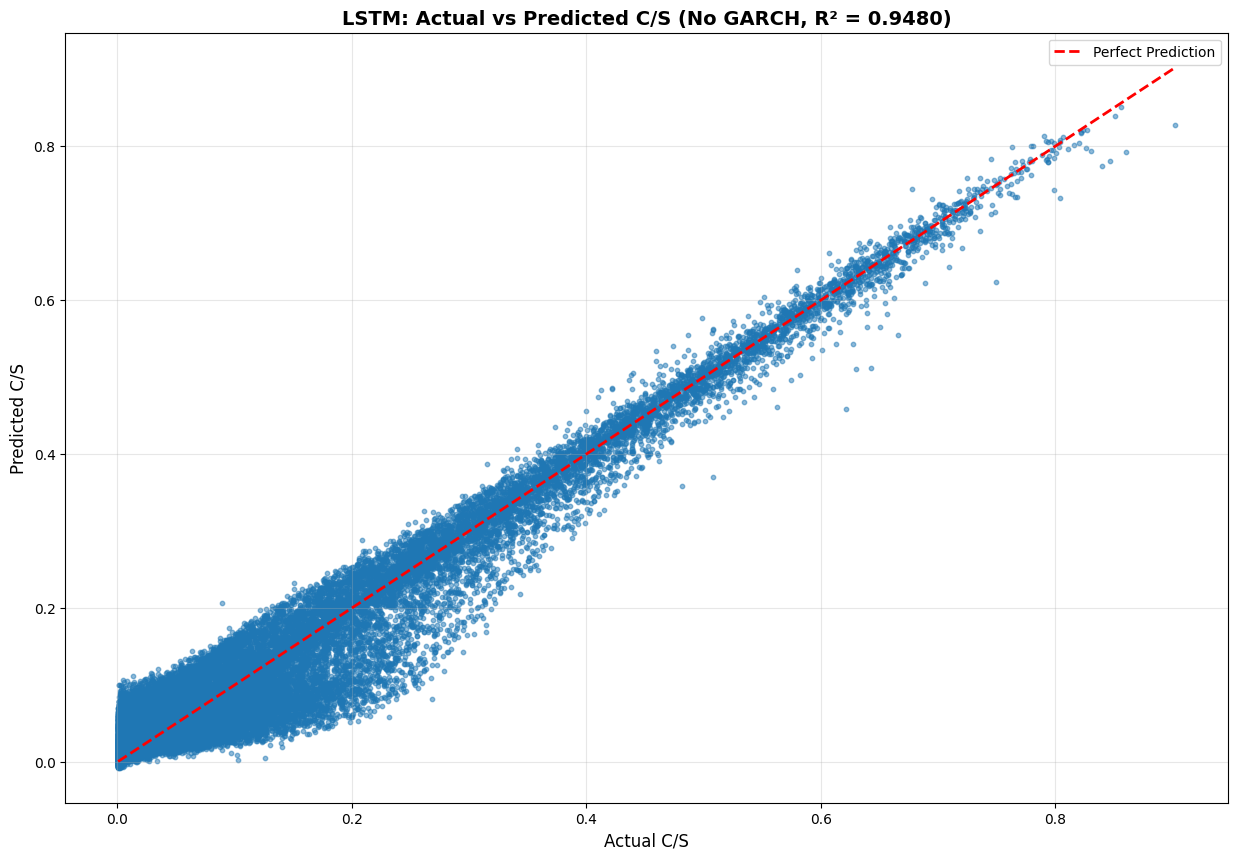


Fraction Error Statistics:
  Min:  -11.262151
  Max:  104.259496
  Mean: 1.898871
  Std:  7.010308


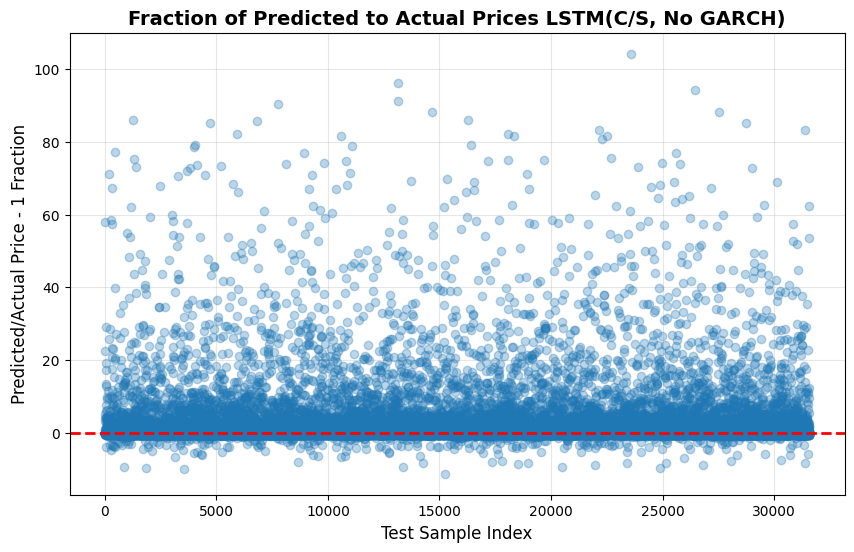

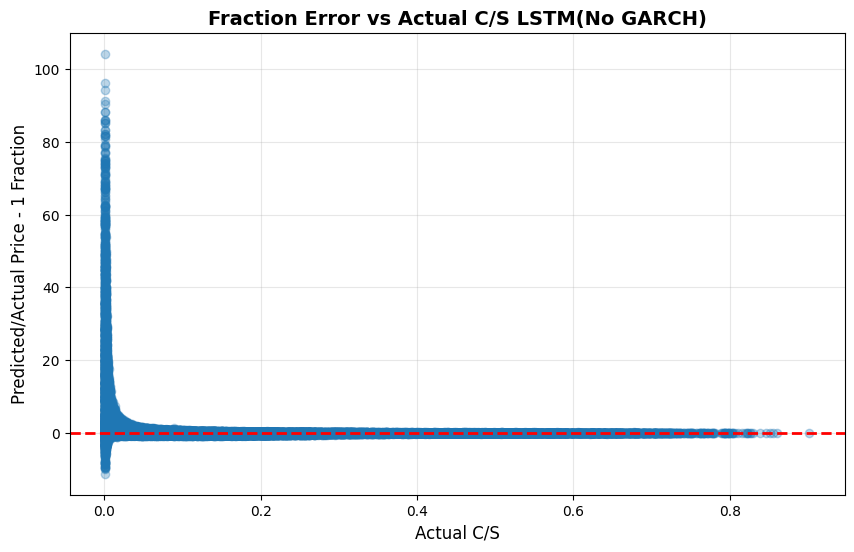

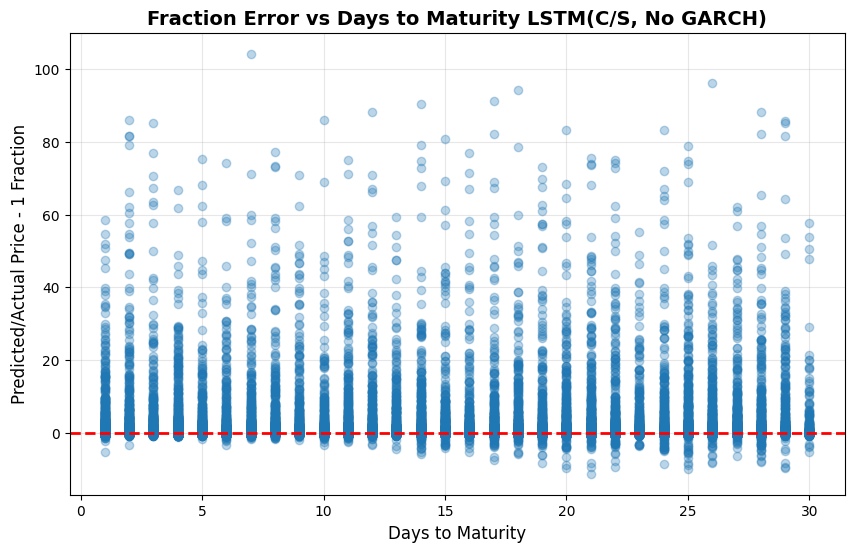

In [38]:
# Visualizations for LSTM on C/S (no GARCH)
# 1. Loss curve
plt.figure(figsize=(10, 6))
plt.plot(lstm_history_cs_no_garch.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in lstm_history_cs_no_garch.history:
    plt.plot(lstm_history_cs_no_garch.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('LSTM Loss Function (C/S, No GARCH)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Scatter plot: Actual vs Predicted
plt.figure(figsize=(15, 10))
plt.scatter(y_test_cs_no_garch, y_pred_lstm_cs_no_garch, alpha=0.5, s=10)
plt.plot([y_test_cs_no_garch.min(), y_test_cs_no_garch.max()], 
         [y_test_cs_no_garch.min(), y_test_cs_no_garch.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual C/S', fontsize=12)
plt.ylabel('Predicted C/S', fontsize=12)
plt.title(f'LSTM: Actual vs Predicted C/S (No GARCH, R² = {r2_lstm_cs_no_garch:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Fraction error plot
fractions_lstm_cs_no_garch = (y_pred_lstm_cs_no_garch / y_test_reset.values) - 1

print("\nFraction Error Statistics:")
print(f"  Min:  {np.min(fractions_lstm_cs_no_garch):.6f}")
print(f"  Max:  {np.max(fractions_lstm_cs_no_garch):.6f}")
print(f"  Mean: {np.mean(fractions_lstm_cs_no_garch):.6f}")
print(f"  Std:  {np.std(fractions_lstm_cs_no_garch):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(fractions_lstm_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction of Predicted to Actual Prices LSTM(C/S, No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Fraction error vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset.values, fractions_lstm_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Actual C/S', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Actual C/S LSTM(No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 5. Fraction error vs Days to Maturity
plt.figure(figsize=(10, 6))
plt.plot(maturity_test_no_garch, fractions_lstm_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Days to Maturity LSTM(C/S, No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()


### 1.4 LSTM Model on log(C/S) (Without GARCH)


In [39]:
# LSTM on log(C/S) without GARCH
print("\n" + "=" * 80)
print("1.4 LSTM Model on log(C/S) (Without GARCH)")
print("=" * 80)

# Reshape for LSTM (use same train-test split as MLP log(C/S))
X_train_lstm_log_no_garch = np.reshape(X_train_scaled_log_no_garch, (X_train_scaled_log_no_garch.shape[0], 1, X_train_scaled_log_no_garch.shape[1]))
X_test_lstm_log_no_garch = np.reshape(X_test_scaled_log_no_garch, (X_test_scaled_log_no_garch.shape[0], 1, X_test_scaled_log_no_garch.shape[1]))

# Create and train LSTM model
lstm_model_log_cs_no_garch = create_lstm_model(input_dim_no_garch)

print(f"Training LSTM on log(C/S) (no GARCH)...")
lstm_start_time = time.time()
lstm_history_log_cs_no_garch = lstm_model_log_cs_no_garch.fit(
    X_train_lstm_log_no_garch, y_train_log_cs_no_garch,
    epochs=OPTIMAL_EPOCHS_LSTM,
    batch_size=OPTIMAL_BATCH_SIZE_LSTM,
    verbose=0,
    validation_split=0.1
)
lstm_training_time = time.time() - lstm_start_time

# Predictions
y_pred_lstm_log_cs_no_garch = lstm_model_log_cs_no_garch.predict(X_test_lstm_log_no_garch, verbose=0).flatten()

# Metrics
rmse_lstm_log_cs_no_garch = np.sqrt(mean_squared_error(y_test_log_cs_no_garch, y_pred_lstm_log_cs_no_garch))
mae_lstm_log_cs_no_garch = mean_absolute_error(y_test_log_cs_no_garch, y_pred_lstm_log_cs_no_garch)
mse_lstm_log_cs_no_garch = mean_squared_error(y_test_log_cs_no_garch, y_pred_lstm_log_cs_no_garch)
r2_lstm_log_cs_no_garch = r2_score(y_test_log_cs_no_garch, y_pred_lstm_log_cs_no_garch)

print(f"\n✓ Training completed in {lstm_training_time:.2f} seconds")
print(f"  RMSE: {rmse_lstm_log_cs_no_garch:.10f}")
print(f"  MAE:  {mae_lstm_log_cs_no_garch:.10f}")
print(f"  MSE:  {mse_lstm_log_cs_no_garch:.10f}")
print(f"  R²:   {r2_lstm_log_cs_no_garch:.6f}")

# Save model
lstm_model_log_cs_no_garch.save('models/lstm_log_cs_without_garch.h5')
print(f"✓ Model saved: models/lstm_log_cs_without_garch.h5")



1.4 LSTM Model on log(C/S) (Without GARCH)
Training LSTM on log(C/S) (no GARCH)...

✓ Training completed in 1194.58 seconds
  RMSE: 0.9469080506
  MAE:  0.7119537357
  MSE:  0.8966348562
  R²:   0.701304
✓ Model saved: models/lstm_log_cs_without_garch.h5


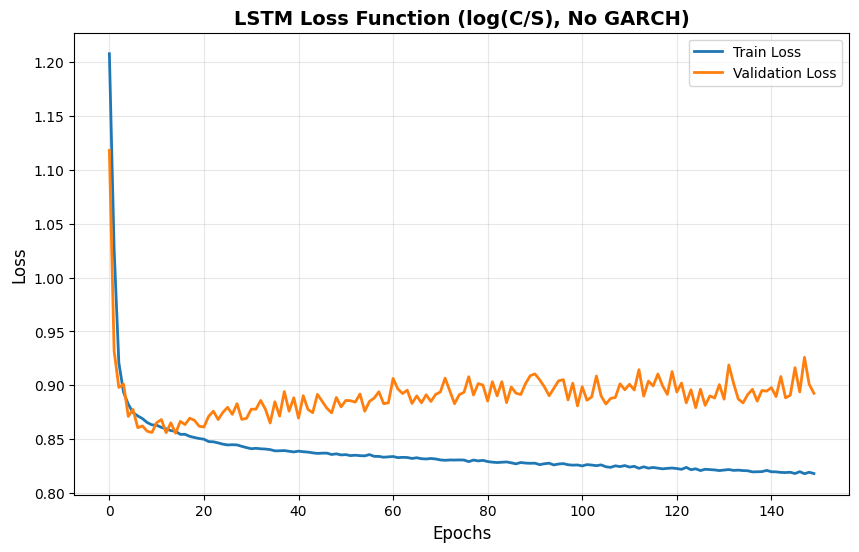

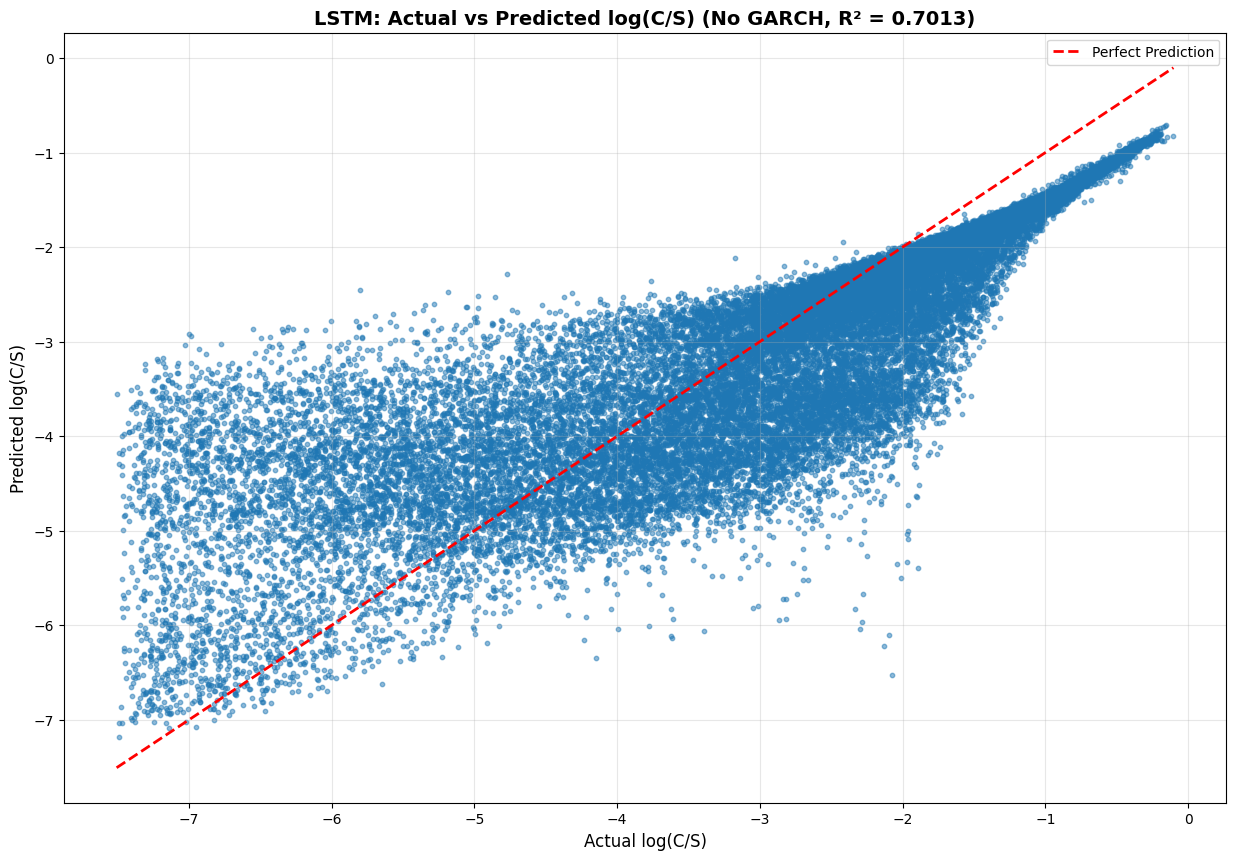


Fraction Error Statistics:
  Min:  -0.582989
  Max:  7.044393
  Mean: 0.204111
  Std:  0.388741


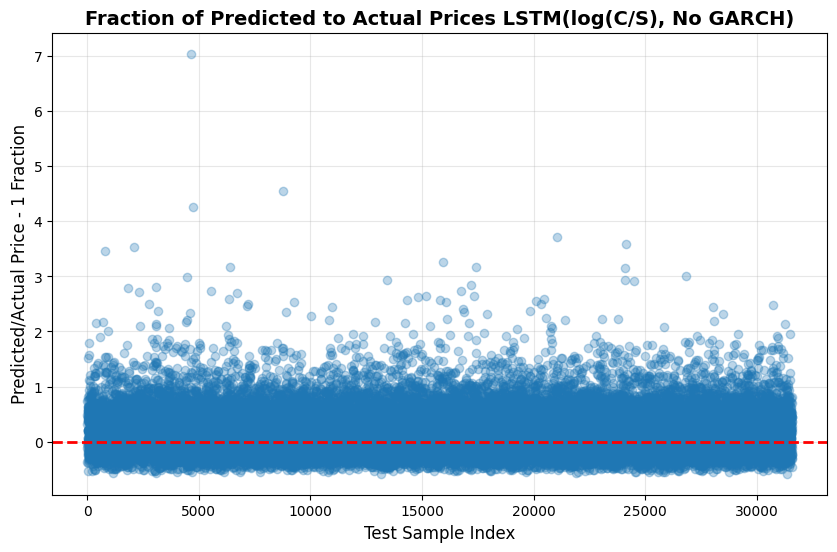

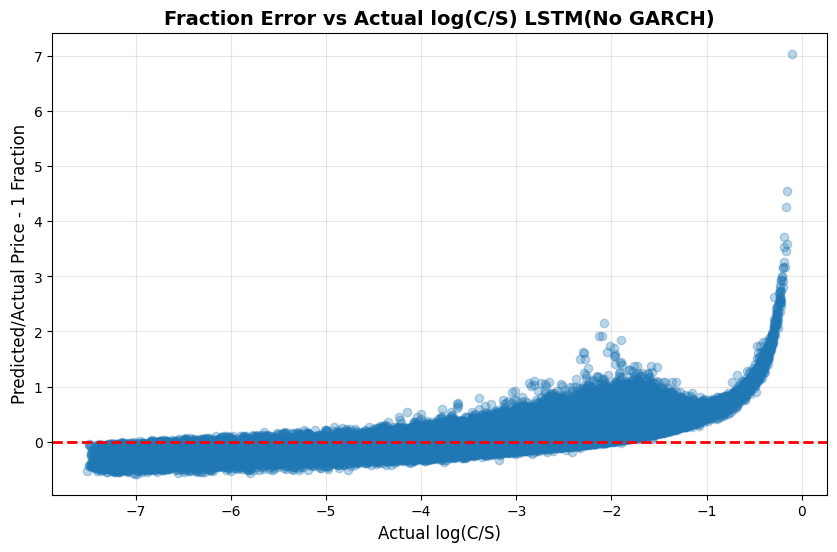

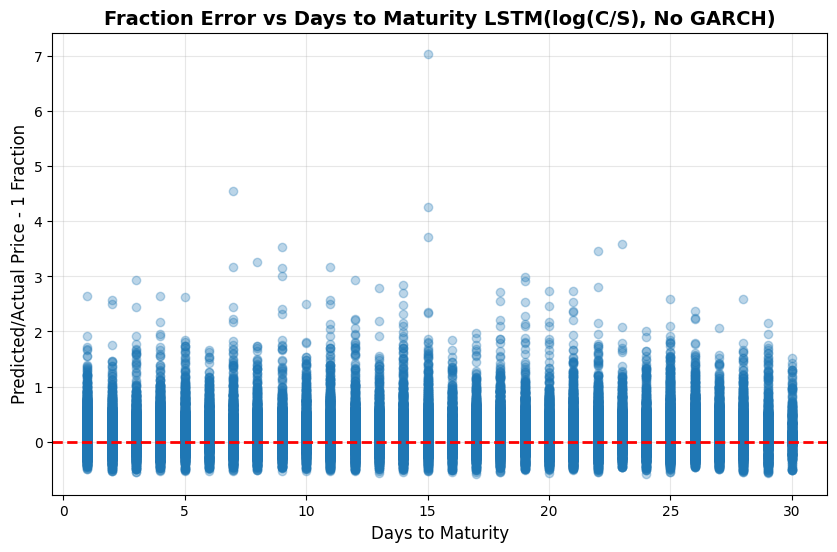


SECTION 1 COMPLETE: All models WITHOUT GARCH trained and evaluated


In [40]:
# Visualizations for LSTM on log(C/S) (no GARCH)
# 1. Loss curve
plt.figure(figsize=(10, 6))
plt.plot(lstm_history_log_cs_no_garch.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in lstm_history_log_cs_no_garch.history:
    plt.plot(lstm_history_log_cs_no_garch.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('LSTM Loss Function (log(C/S), No GARCH)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Scatter plot: Actual vs Predicted
plt.figure(figsize=(15, 10))
plt.scatter(y_test_log_cs_no_garch, y_pred_lstm_log_cs_no_garch, alpha=0.5, s=10)
plt.plot([y_test_log_cs_no_garch.min(), y_test_log_cs_no_garch.max()], 
         [y_test_log_cs_no_garch.min(), y_test_log_cs_no_garch.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual log(C/S)', fontsize=12)
plt.ylabel('Predicted log(C/S)', fontsize=12)
plt.title(f'LSTM: Actual vs Predicted log(C/S) (No GARCH, R² = {r2_lstm_log_cs_no_garch:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Fraction error plot
fractions_lstm_log_cs_no_garch = (y_pred_lstm_log_cs_no_garch / y_test_log_reset.values) - 1

print("\nFraction Error Statistics:")
print(f"  Min:  {np.min(fractions_lstm_log_cs_no_garch):.6f}")
print(f"  Max:  {np.max(fractions_lstm_log_cs_no_garch):.6f}")
print(f"  Mean: {np.mean(fractions_lstm_log_cs_no_garch):.6f}")
print(f"  Std:  {np.std(fractions_lstm_log_cs_no_garch):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(fractions_lstm_log_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction of Predicted to Actual Prices LSTM(log(C/S), No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Fraction error vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_log_reset.values, fractions_lstm_log_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Actual log(C/S)', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Actual log(C/S) LSTM(No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 5. Fraction error vs Days to Maturity
plt.figure(figsize=(10, 6))
plt.plot(maturity_test_log_no_garch, fractions_lstm_log_cs_no_garch, 'o', alpha=0.3)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Days to Maturity LSTM(log(C/S), No GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "=" * 80)
print("SECTION 1 COMPLETE: All models WITHOUT GARCH trained and evaluated")
print("=" * 80)


---

## Section 2: Models WITH GARCH Features

In this section, we train models using features including GARCH conditional volatility: `IV`, `K/S`, `Maturity`, `r`, and `cond_vol`.

We'll train:
1. MLP on C/S
2. MLP on log(C/S)
3. LSTM on C/S
4. LSTM on log(C/S)

Each model will be evaluated with metrics and visualizations.


In [41]:
# ============================================================================
# SECTION 2: WITH GARCH
# ============================================================================

# Verify data is available
if 'data' not in globals() or data is None:
    raise NameError("'data' variable not found. Please run the data loading cell (cell 38) first!")

# Verify OPTIMAL constants are defined
if 'OPTIMAL_EPOCHS_MLP' not in globals() or 'OPTIMAL_BATCH_SIZE_MLP' not in globals():
    raise NameError("OPTIMAL constants not found. Please run cell 35 (hyperparameters cell) first!")

# Verify model functions are defined
if 'create_mlp_model' not in globals() or 'create_lstm_model' not in globals():
    raise NameError("Model functions not found. Please run cell 37 (model definitions) first!")

# Feature columns WITH GARCH
feature_columns_with_garch = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']

print("\n" + "=" * 80)
print("SECTION 2: TRAINING MODELS WITH GARCH FEATURES")
print("=" * 80)
print(f"Features: {feature_columns_with_garch}")
print(f"Targets: {target_column_cs} and {target_column_log_cs}")
print("=" * 80)

# Check if GARCH data is available
if 'cond_vol' not in data.columns:
    print("\n⚠ WARNING: GARCH conditional volatility column 'cond_vol' not found!")
    print("  Using IV as cond_vol fallback...")
    data['cond_vol'] = data['IV'].copy()
elif data['cond_vol'].isna().all():
    print("\n⚠ WARNING: GARCH conditional volatility is all NaN!")
    print("  Using IV as cond_vol fallback...")
    data['cond_vol'] = data['IV'].copy()

# Verify all required columns exist
required_cols_garch = feature_columns_with_garch + [target_column_cs, target_column_log_cs]
missing_cols = [col for col in required_cols_garch if col not in data.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}. Available columns: {data.columns.tolist()}")

# Prepare data with GARCH
data_with_garch = data[required_cols_garch].dropna()
print(f"\n✓ Clean data (with GARCH): {len(data_with_garch):,} rows")
if len(data_with_garch) == 0:
    raise ValueError("No data available after cleaning! Check for missing values.")



SECTION 2: TRAINING MODELS WITH GARCH FEATURES
Features: ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
Targets: C/S and log_C_S

✓ Clean data (with GARCH): 157,919 rows


### 2.1 MLP Model on C/S (With GARCH)


In [42]:
# MLP on C/S with GARCH
print("\n" + "=" * 80)
print("2.1 MLP Model on C/S (With GARCH)")
print("=" * 80)

# Prepare features and target
X_with_garch = data_with_garch[feature_columns_with_garch]
y_cs_with_garch = data_with_garch[target_column_cs]

# Train-test split
X_train_with_garch, X_test_with_garch, y_train_cs_with_garch, y_test_cs_with_garch = train_test_split(
    X_with_garch, y_cs_with_garch, test_size=0.2, random_state=42
)

# Scale features
scaler_with_garch = StandardScaler()
X_train_scaled_with_garch = scaler_with_garch.fit_transform(X_train_with_garch)
X_test_scaled_with_garch = scaler_with_garch.transform(X_test_with_garch)

# Create and train MLP model
input_dim_with_garch = X_train_scaled_with_garch.shape[1]
mlp_model_cs_with_garch = create_mlp_model(input_dim_with_garch)

print(f"Training MLP on C/S (with GARCH)...")
mlp_start_time = time.time()
mlp_history_cs_with_garch = mlp_model_cs_with_garch.fit(
    X_train_scaled_with_garch, y_train_cs_with_garch,
    epochs=OPTIMAL_EPOCHS_MLP,
    batch_size=OPTIMAL_BATCH_SIZE_MLP,
    verbose=0,
    validation_split=0.1
)
mlp_training_time = time.time() - mlp_start_time

# Predictions
y_pred_mlp_cs_with_garch = mlp_model_cs_with_garch.predict(X_test_scaled_with_garch, verbose=0).flatten()

# Metrics
rmse_mlp_cs_with_garch = np.sqrt(mean_squared_error(y_test_cs_with_garch, y_pred_mlp_cs_with_garch))
mae_mlp_cs_with_garch = mean_absolute_error(y_test_cs_with_garch, y_pred_mlp_cs_with_garch)
mse_mlp_cs_with_garch = mean_squared_error(y_test_cs_with_garch, y_pred_mlp_cs_with_garch)
r2_mlp_cs_with_garch = r2_score(y_test_cs_with_garch, y_pred_mlp_cs_with_garch)

print(f"\n✓ Training completed in {mlp_training_time:.2f} seconds")
print(f"  RMSE: {rmse_mlp_cs_with_garch:.10f}")
print(f"  MAE:  {mae_mlp_cs_with_garch:.10f}")
print(f"  MSE:  {mse_mlp_cs_with_garch:.10f}")
print(f"  R²:   {r2_mlp_cs_with_garch:.6f}")

# Save model
mlp_model_cs_with_garch.save('models/mlp_cs_with_garch.h5')
print(f"✓ Model saved: models/mlp_cs_with_garch.h5")



2.1 MLP Model on C/S (With GARCH)
Training MLP on C/S (with GARCH)...

✓ Training completed in 190.16 seconds
  RMSE: 0.0366860832
  MAE:  0.0277512680
  MSE:  0.0013458687
  R²:   0.945716
✓ Model saved: models/mlp_cs_with_garch.h5


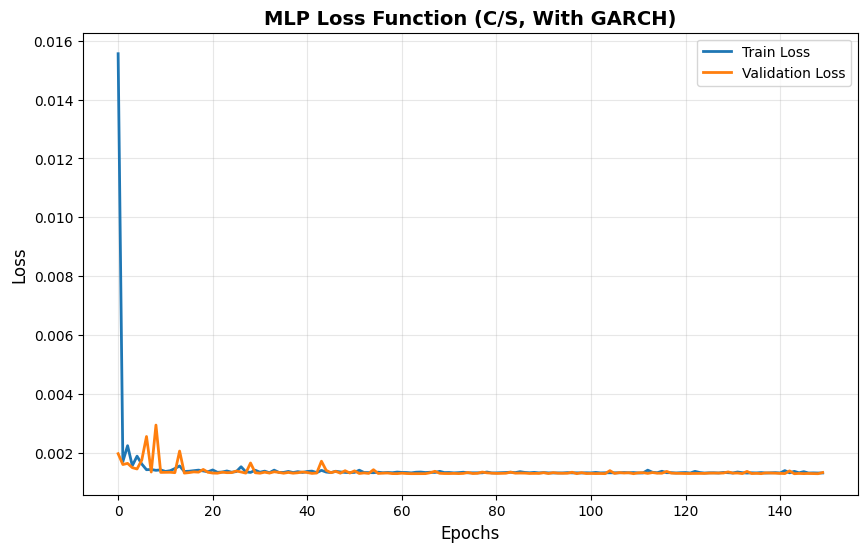

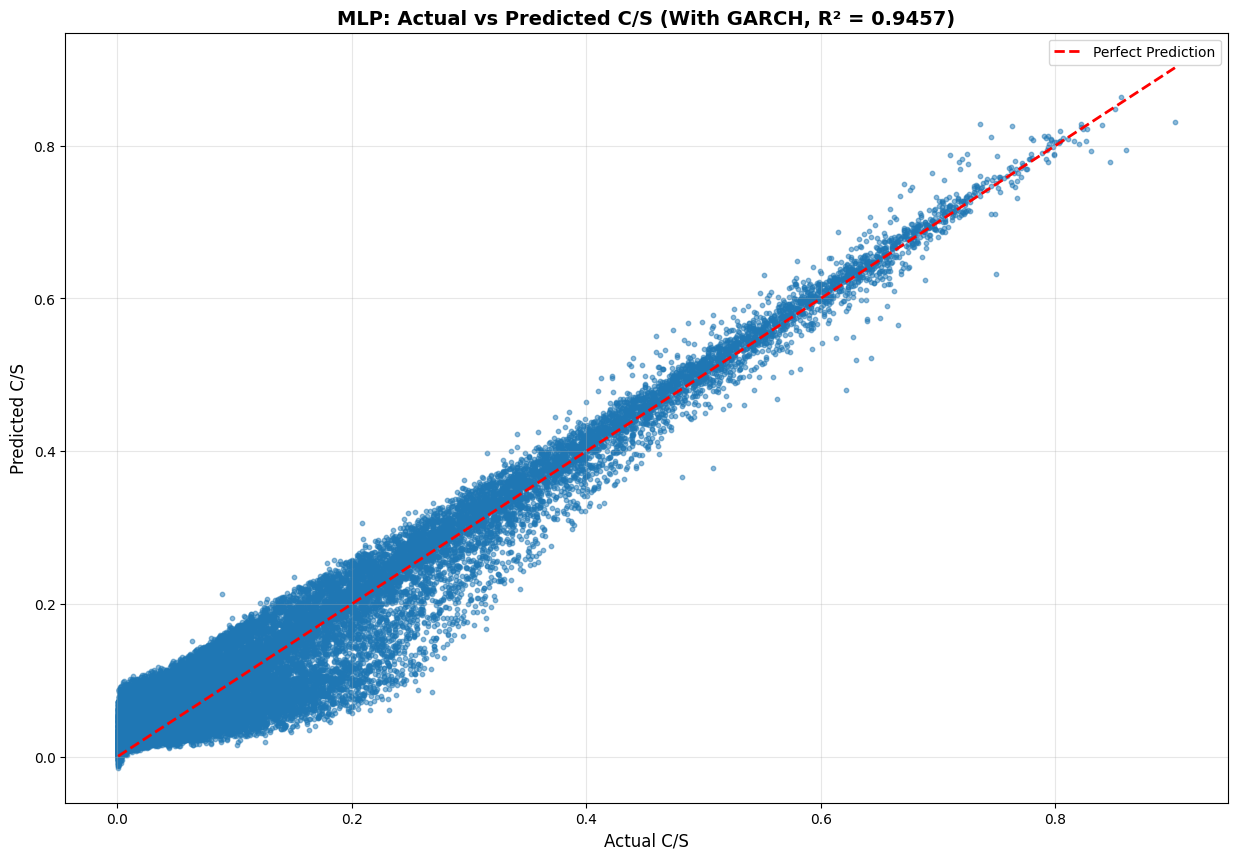


Fraction Error Statistics:
  Min:  -24.846919
  Max:  113.394720
  Mean: 2.525123
  Std:  8.006838


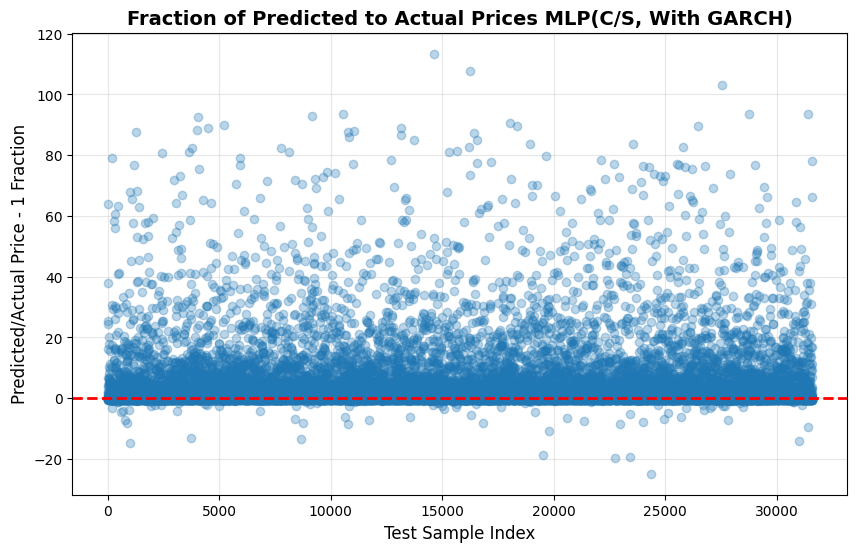

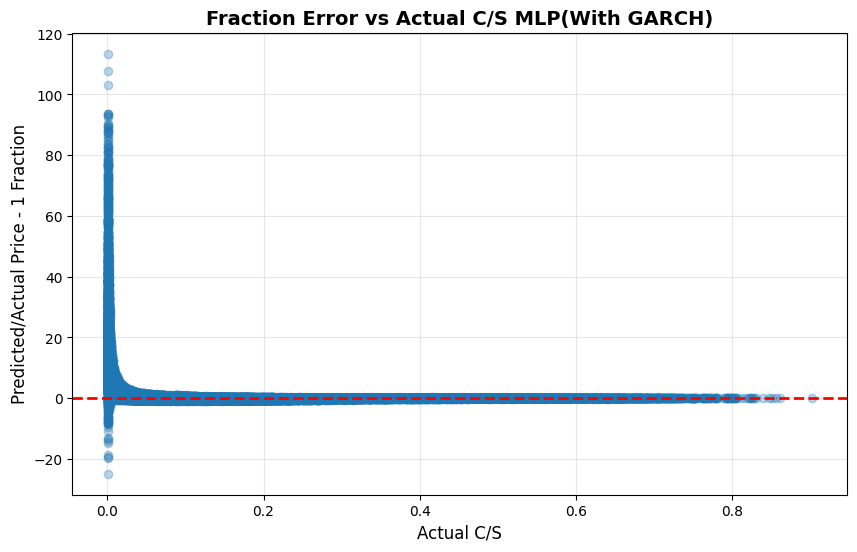

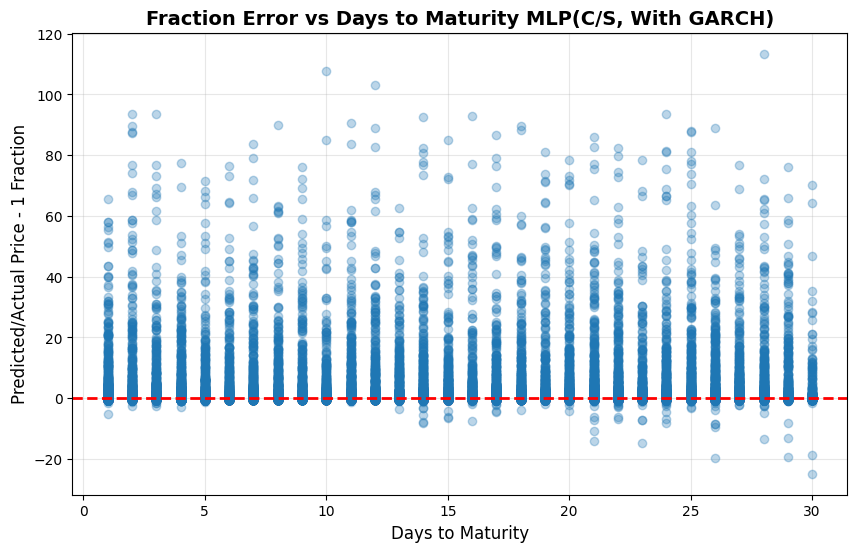

In [43]:
# Visualizations for MLP on C/S (with GARCH)
# 1. Loss curve
plt.figure(figsize=(10, 6))
plt.plot(mlp_history_cs_with_garch.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in mlp_history_cs_with_garch.history:
    plt.plot(mlp_history_cs_with_garch.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('MLP Loss Function (C/S, With GARCH)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Scatter plot: Actual vs Predicted
plt.figure(figsize=(15, 10))
plt.scatter(y_test_cs_with_garch, y_pred_mlp_cs_with_garch, alpha=0.5, s=10)
plt.plot([y_test_cs_with_garch.min(), y_test_cs_with_garch.max()], 
         [y_test_cs_with_garch.min(), y_test_cs_with_garch.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual C/S', fontsize=12)
plt.ylabel('Predicted C/S', fontsize=12)
plt.title(f'MLP: Actual vs Predicted C/S (With GARCH, R² = {r2_mlp_cs_with_garch:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Fraction error plot
y_test_reset_garch = y_test_cs_with_garch.reset_index(drop=True)
fractions_mlp_cs_with_garch = (y_pred_mlp_cs_with_garch / y_test_reset_garch.values) - 1

print("\nFraction Error Statistics:")
print(f"  Min:  {np.min(fractions_mlp_cs_with_garch):.6f}")
print(f"  Max:  {np.max(fractions_mlp_cs_with_garch):.6f}")
print(f"  Mean: {np.mean(fractions_mlp_cs_with_garch):.6f}")
print(f"  Std:  {np.std(fractions_mlp_cs_with_garch):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(fractions_mlp_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction of Predicted to Actual Prices MLP(C/S, With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Fraction error vs Actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset_garch.values, fractions_mlp_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Actual C/S', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Actual C/S MLP(With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# 5. Fraction error vs Days to Maturity
maturity_test_with_garch = X_test_with_garch['Maturity'].values * 252
plt.figure(figsize=(10, 6))
plt.plot(maturity_test_with_garch, fractions_mlp_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Days to Maturity MLP(C/S, With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()


### 2.2 MLP Model on log(C/S) (With GARCH)


In [44]:
# MLP on log(C/S) with GARCH
print("\n" + "=" * 80)
print("2.2 MLP Model on log(C/S) (With GARCH)")
print("=" * 80)

# Prepare target
y_log_cs_with_garch = data_with_garch[target_column_log_cs]

# Train-test split
X_train_log_with_garch, X_test_log_with_garch, y_train_log_cs_with_garch, y_test_log_cs_with_garch = train_test_split(
    X_with_garch, y_log_cs_with_garch, test_size=0.2, random_state=42
)

# Scale features
X_train_scaled_log_with_garch = scaler_with_garch.fit_transform(X_train_log_with_garch)
X_test_scaled_log_with_garch = scaler_with_garch.transform(X_test_log_with_garch)

# Create and train MLP model
mlp_model_log_cs_with_garch = create_mlp_model(input_dim_with_garch)

print(f"Training MLP on log(C/S) (with GARCH)...")
mlp_start_time = time.time()
mlp_history_log_cs_with_garch = mlp_model_log_cs_with_garch.fit(
    X_train_scaled_log_with_garch, y_train_log_cs_with_garch,
    epochs=OPTIMAL_EPOCHS_MLP,
    batch_size=OPTIMAL_BATCH_SIZE_MLP,
    verbose=0,
    validation_split=0.1
)
mlp_training_time = time.time() - mlp_start_time

# Predictions
y_pred_mlp_log_cs_with_garch = mlp_model_log_cs_with_garch.predict(X_test_scaled_log_with_garch, verbose=0).flatten()

# Metrics
rmse_mlp_log_cs_with_garch = np.sqrt(mean_squared_error(y_test_log_cs_with_garch, y_pred_mlp_log_cs_with_garch))
mae_mlp_log_cs_with_garch = mean_absolute_error(y_test_log_cs_with_garch, y_pred_mlp_log_cs_with_garch)
mse_mlp_log_cs_with_garch = mean_squared_error(y_test_log_cs_with_garch, y_pred_mlp_log_cs_with_garch)
r2_mlp_log_cs_with_garch = r2_score(y_test_log_cs_with_garch, y_pred_mlp_log_cs_with_garch)

print(f"\n✓ Training completed in {mlp_training_time:.2f} seconds")
print(f"  RMSE: {rmse_mlp_log_cs_with_garch:.10f}")
print(f"  MAE:  {mae_mlp_log_cs_with_garch:.10f}")
print(f"  MSE:  {mse_mlp_log_cs_with_garch:.10f}")
print(f"  R²:   {r2_mlp_log_cs_with_garch:.6f}")

# Save model
mlp_model_log_cs_with_garch.save('models/mlp_log_cs_with_garch.h5')
print(f"✓ Model saved: models/mlp_log_cs_with_garch.h5")



2.2 MLP Model on log(C/S) (With GARCH)
Training MLP on log(C/S) (with GARCH)...

✓ Training completed in 187.09 seconds
  RMSE: 0.9239355379
  MAE:  0.6271664026
  MSE:  0.8536568783
  R²:   0.715621
✓ Model saved: models/mlp_log_cs_with_garch.h5


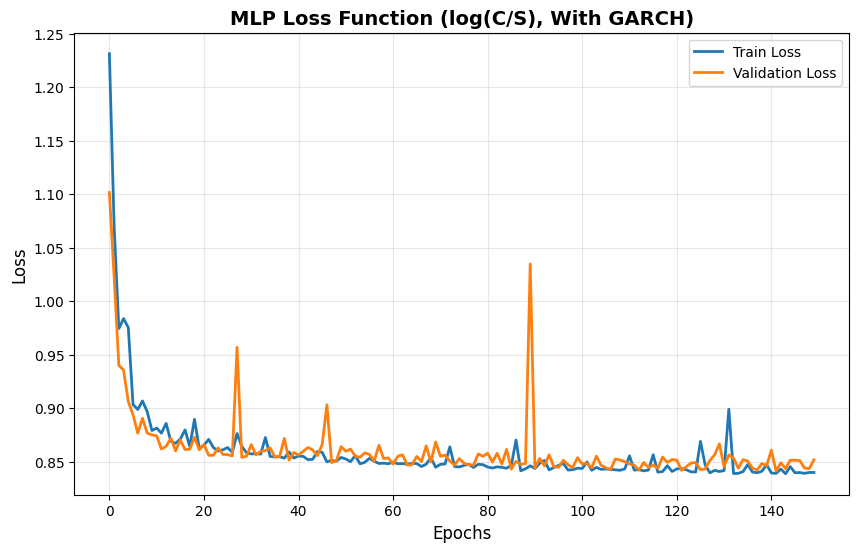

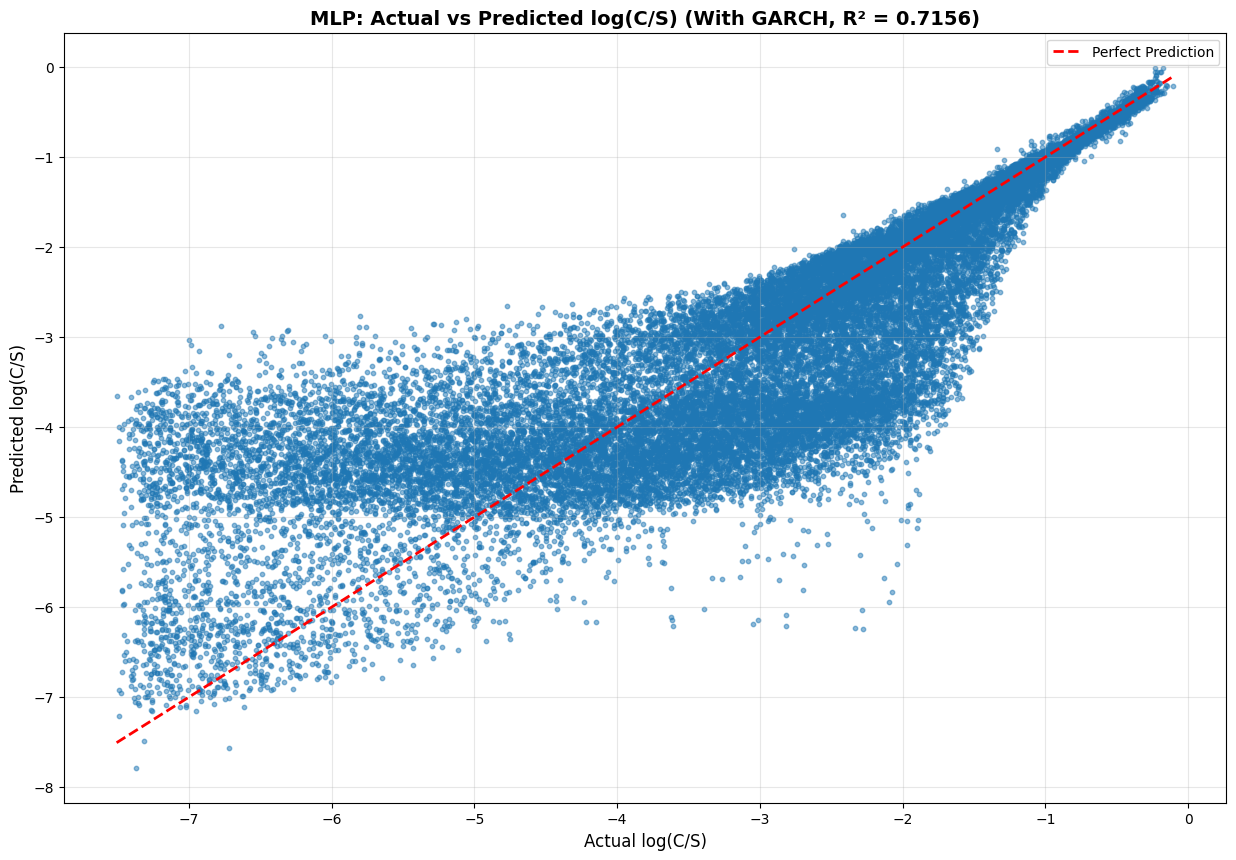


Fraction Error Statistics:
  Min:  -0.966437
  Max:  1.836556
  Mean: 0.073533
  Std:  0.278108


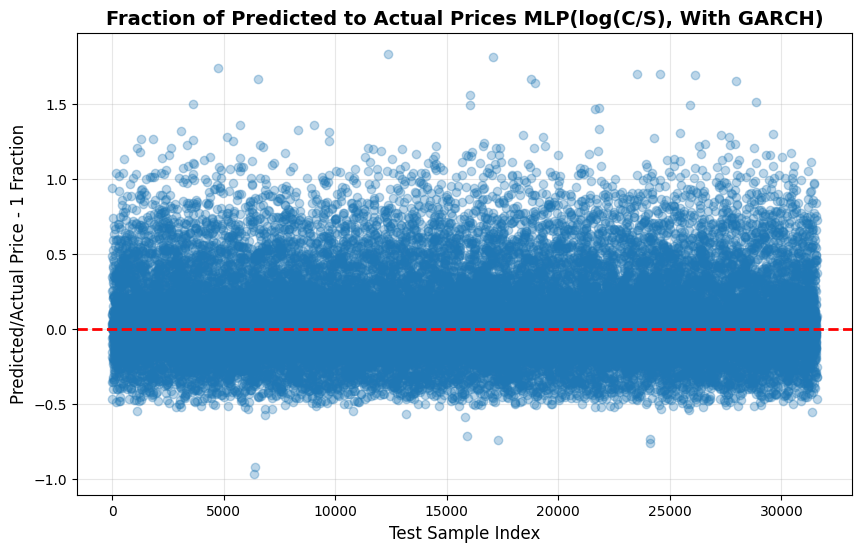

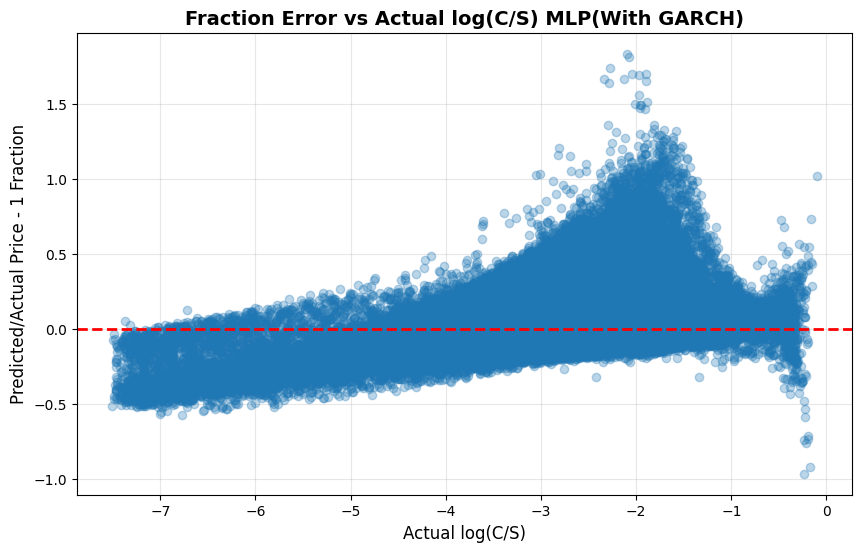

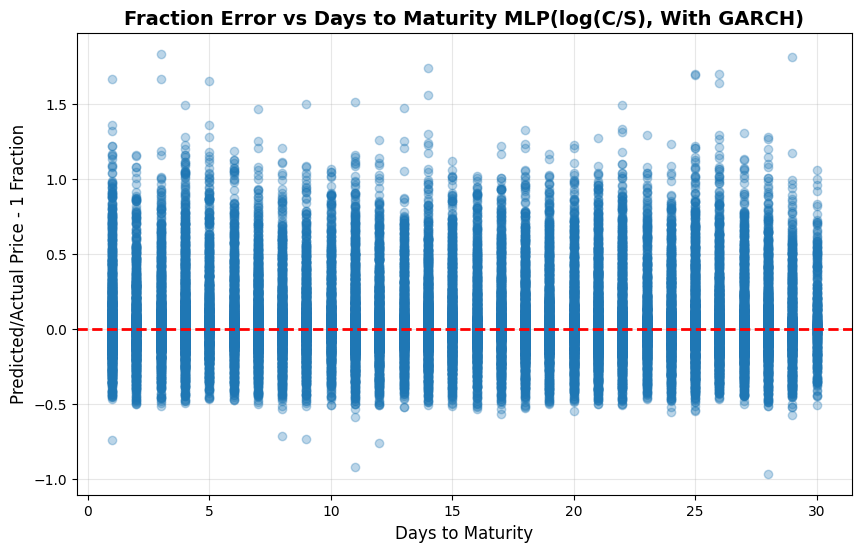

In [45]:
# Visualizations for MLP on log(C/S) (with GARCH) - Same structure as previous
plt.figure(figsize=(10, 6))
plt.plot(mlp_history_log_cs_with_garch.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in mlp_history_log_cs_with_garch.history:
    plt.plot(mlp_history_log_cs_with_garch.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('MLP Loss Function (log(C/S), With GARCH)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(15, 10))
plt.scatter(y_test_log_cs_with_garch, y_pred_mlp_log_cs_with_garch, alpha=0.5, s=10)
plt.plot([y_test_log_cs_with_garch.min(), y_test_log_cs_with_garch.max()], 
         [y_test_log_cs_with_garch.min(), y_test_log_cs_with_garch.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual log(C/S)', fontsize=12)
plt.ylabel('Predicted log(C/S)', fontsize=12)
plt.title(f'MLP: Actual vs Predicted log(C/S) (With GARCH, R² = {r2_mlp_log_cs_with_garch:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

y_test_log_reset_garch = y_test_log_cs_with_garch.reset_index(drop=True)
fractions_mlp_log_cs_with_garch = (y_pred_mlp_log_cs_with_garch / y_test_log_reset_garch.values) - 1

print("\nFraction Error Statistics:")
print(f"  Min:  {np.min(fractions_mlp_log_cs_with_garch):.6f}")
print(f"  Max:  {np.max(fractions_mlp_log_cs_with_garch):.6f}")
print(f"  Mean: {np.mean(fractions_mlp_log_cs_with_garch):.6f}")
print(f"  Std:  {np.std(fractions_mlp_log_cs_with_garch):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(fractions_mlp_log_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction of Predicted to Actual Prices MLP(log(C/S), With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test_log_reset_garch.values, fractions_mlp_log_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Actual log(C/S)', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Actual log(C/S) MLP(With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

maturity_test_log_with_garch = X_test_log_with_garch['Maturity'].values * 252
plt.figure(figsize=(10, 6))
plt.plot(maturity_test_log_with_garch, fractions_mlp_log_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Days to Maturity MLP(log(C/S), With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()


### 2.3 LSTM Model on C/S (With GARCH)


In [46]:
# LSTM on C/S with GARCH
print("\n" + "=" * 80)
print("2.3 LSTM Model on C/S (With GARCH)")
print("=" * 80)

# Reshape for LSTM
X_train_lstm_with_garch = np.reshape(X_train_scaled_with_garch, (X_train_scaled_with_garch.shape[0], 1, X_train_scaled_with_garch.shape[1]))
X_test_lstm_with_garch = np.reshape(X_test_scaled_with_garch, (X_test_scaled_with_garch.shape[0], 1, X_test_scaled_with_garch.shape[1]))

# Create and train LSTM model
lstm_model_cs_with_garch = create_lstm_model(input_dim_with_garch)

print(f"Training LSTM on C/S (with GARCH)...")
lstm_start_time = time.time()
lstm_history_cs_with_garch = lstm_model_cs_with_garch.fit(
    X_train_lstm_with_garch, y_train_cs_with_garch,
    epochs=OPTIMAL_EPOCHS_LSTM,
    batch_size=OPTIMAL_BATCH_SIZE_LSTM,
    verbose=0,
    validation_split=0.1
)
lstm_training_time = time.time() - lstm_start_time

# Predictions
y_pred_lstm_cs_with_garch = lstm_model_cs_with_garch.predict(X_test_lstm_with_garch, verbose=0).flatten()

# Metrics
rmse_lstm_cs_with_garch = np.sqrt(mean_squared_error(y_test_cs_with_garch, y_pred_lstm_cs_with_garch))
mae_lstm_cs_with_garch = mean_absolute_error(y_test_cs_with_garch, y_pred_lstm_cs_with_garch)
mse_lstm_cs_with_garch = mean_squared_error(y_test_cs_with_garch, y_pred_lstm_cs_with_garch)
r2_lstm_cs_with_garch = r2_score(y_test_cs_with_garch, y_pred_lstm_cs_with_garch)

print(f"\n✓ Training completed in {lstm_training_time:.2f} seconds")
print(f"  RMSE: {rmse_lstm_cs_with_garch:.10f}")
print(f"  MAE:  {mae_lstm_cs_with_garch:.10f}")
print(f"  MSE:  {mse_lstm_cs_with_garch:.10f}")
print(f"  R²:   {r2_lstm_cs_with_garch:.6f}")

# Save model
lstm_model_cs_with_garch.save('models/lstm_cs_with_garch.h5')
print(f"✓ Model saved: models/lstm_cs_with_garch.h5")



2.3 LSTM Model on C/S (With GARCH)
Training LSTM on C/S (with GARCH)...

✓ Training completed in 1188.33 seconds
  RMSE: 0.0360045970
  MAE:  0.0258059981
  MSE:  0.0012963310
  R²:   0.947714
✓ Model saved: models/lstm_cs_with_garch.h5


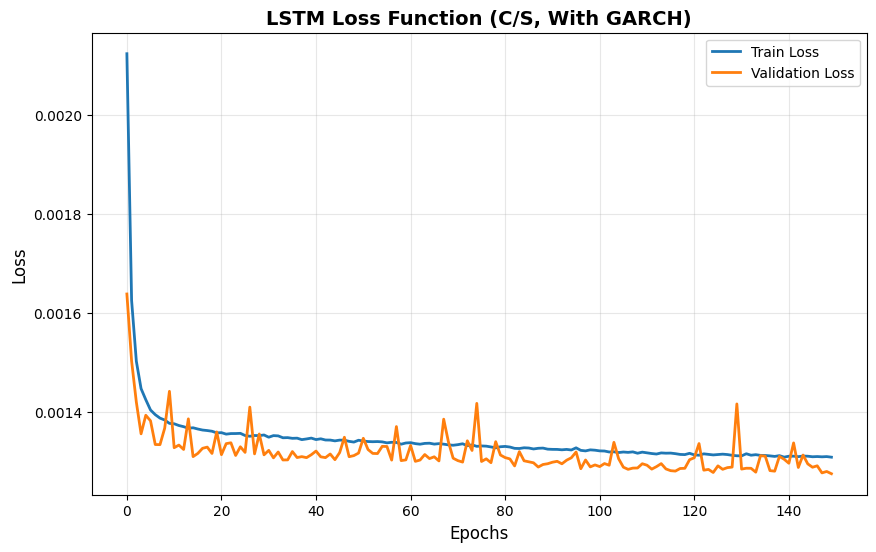

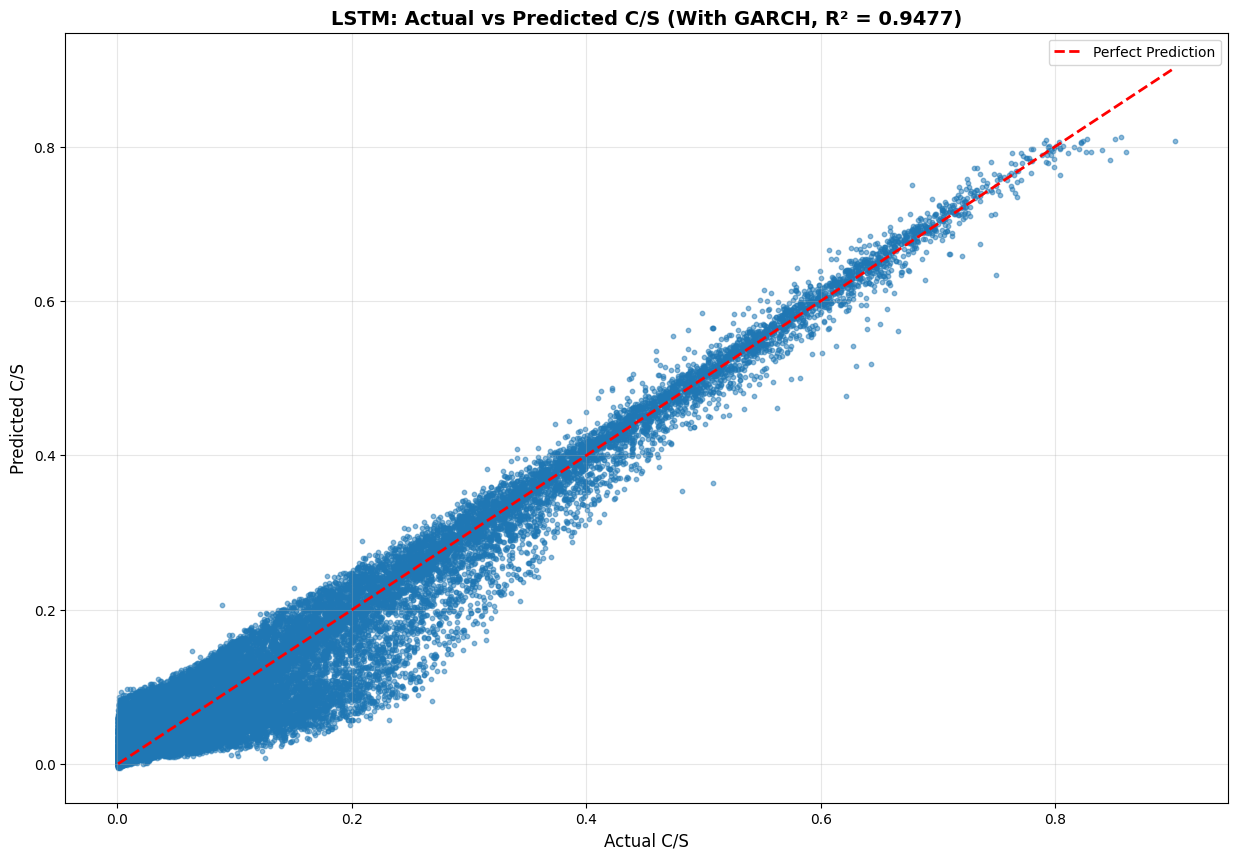


Fraction Error Statistics:
  Min:  -8.328876
  Max:  98.608409
  Mean: 1.877227
  Std:  6.769631


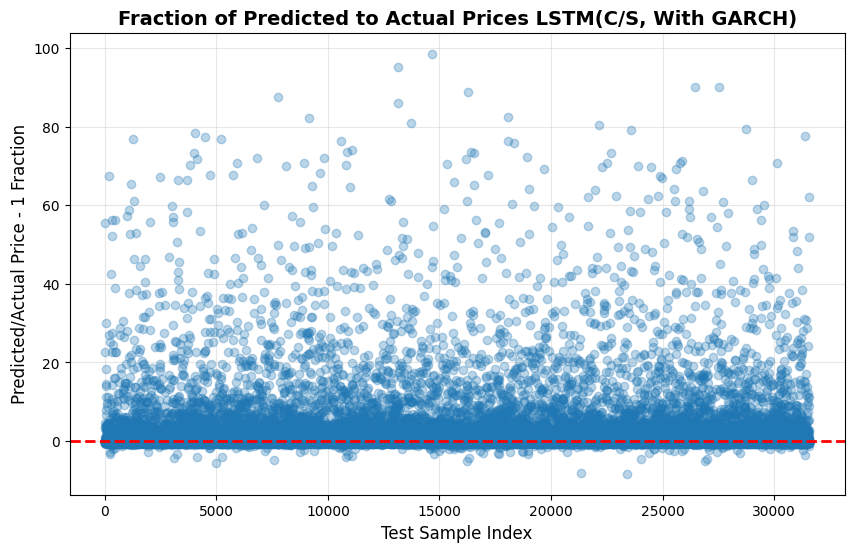

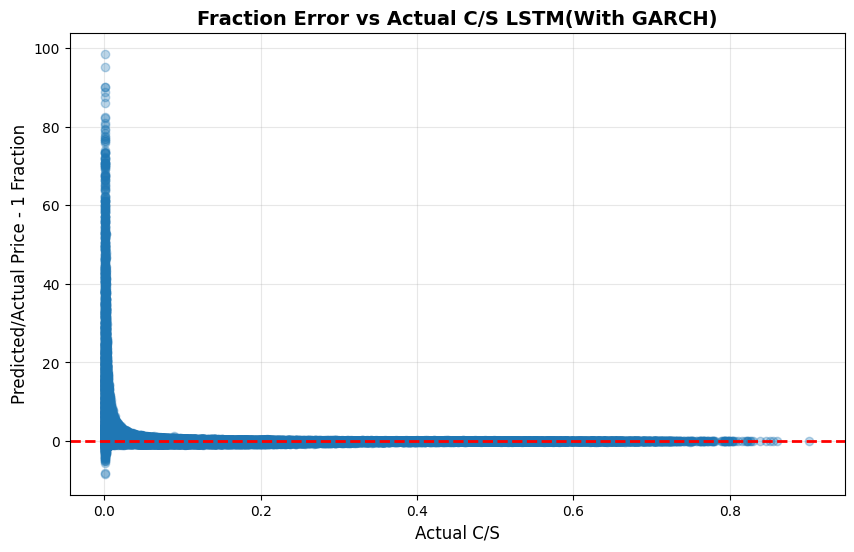

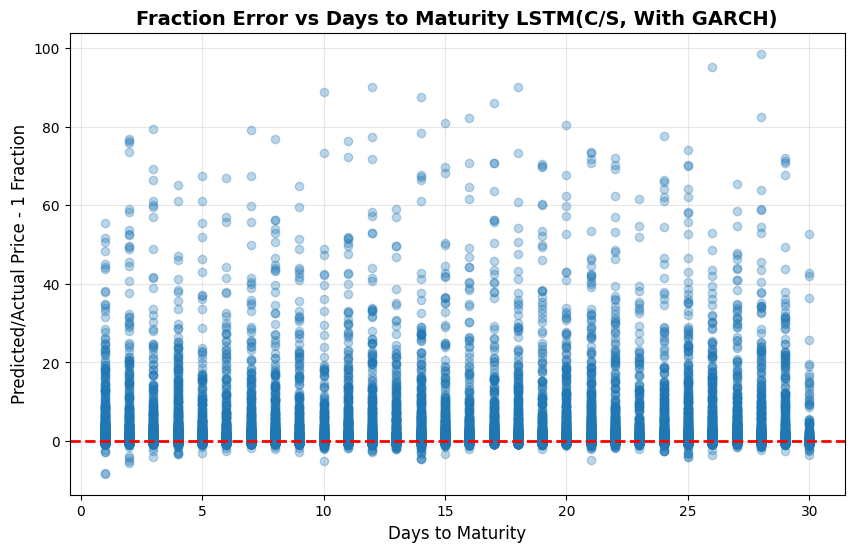

In [47]:
# Visualizations for LSTM on C/S (with GARCH)
plt.figure(figsize=(10, 6))
plt.plot(lstm_history_cs_with_garch.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in lstm_history_cs_with_garch.history:
    plt.plot(lstm_history_cs_with_garch.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('LSTM Loss Function (C/S, With GARCH)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(15, 10))
plt.scatter(y_test_cs_with_garch, y_pred_lstm_cs_with_garch, alpha=0.5, s=10)
plt.plot([y_test_cs_with_garch.min(), y_test_cs_with_garch.max()], 
         [y_test_cs_with_garch.min(), y_test_cs_with_garch.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual C/S', fontsize=12)
plt.ylabel('Predicted C/S', fontsize=12)
plt.title(f'LSTM: Actual vs Predicted C/S (With GARCH, R² = {r2_lstm_cs_with_garch:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

fractions_lstm_cs_with_garch = (y_pred_lstm_cs_with_garch / y_test_reset_garch.values) - 1

print("\nFraction Error Statistics:")
print(f"  Min:  {np.min(fractions_lstm_cs_with_garch):.6f}")
print(f"  Max:  {np.max(fractions_lstm_cs_with_garch):.6f}")
print(f"  Mean: {np.mean(fractions_lstm_cs_with_garch):.6f}")
print(f"  Std:  {np.std(fractions_lstm_cs_with_garch):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(fractions_lstm_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction of Predicted to Actual Prices LSTM(C/S, With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test_reset_garch.values, fractions_lstm_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Actual C/S', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Actual C/S LSTM(With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(maturity_test_with_garch, fractions_lstm_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Days to Maturity LSTM(C/S, With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()


### 2.4 LSTM Model on log(C/S) (With GARCH)


In [48]:
# LSTM on log(C/S) with GARCH
print("\n" + "=" * 80)
print("2.4 LSTM Model on log(C/S) (With GARCH)")
print("=" * 80)

# Reshape for LSTM
X_train_lstm_log_with_garch = np.reshape(X_train_scaled_log_with_garch, (X_train_scaled_log_with_garch.shape[0], 1, X_train_scaled_log_with_garch.shape[1]))
X_test_lstm_log_with_garch = np.reshape(X_test_scaled_log_with_garch, (X_test_scaled_log_with_garch.shape[0], 1, X_test_scaled_log_with_garch.shape[1]))

# Create and train LSTM model
lstm_model_log_cs_with_garch = create_lstm_model(input_dim_with_garch)

print(f"Training LSTM on log(C/S) (with GARCH)...")
lstm_start_time = time.time()
lstm_history_log_cs_with_garch = lstm_model_log_cs_with_garch.fit(
    X_train_lstm_log_with_garch, y_train_log_cs_with_garch,
    epochs=OPTIMAL_EPOCHS_LSTM,
    batch_size=OPTIMAL_BATCH_SIZE_LSTM,
    verbose=0,
    validation_split=0.1
)
lstm_training_time = time.time() - lstm_start_time

# Predictions
y_pred_lstm_log_cs_with_garch = lstm_model_log_cs_with_garch.predict(X_test_lstm_log_with_garch, verbose=0).flatten()

# Metrics
rmse_lstm_log_cs_with_garch = np.sqrt(mean_squared_error(y_test_log_cs_with_garch, y_pred_lstm_log_cs_with_garch))
mae_lstm_log_cs_with_garch = mean_absolute_error(y_test_log_cs_with_garch, y_pred_lstm_log_cs_with_garch)
mse_lstm_log_cs_with_garch = mean_squared_error(y_test_log_cs_with_garch, y_pred_lstm_log_cs_with_garch)
r2_lstm_log_cs_with_garch = r2_score(y_test_log_cs_with_garch, y_pred_lstm_log_cs_with_garch)

print(f"\n✓ Training completed in {lstm_training_time:.2f} seconds")
print(f"  RMSE: {rmse_lstm_log_cs_with_garch:.10f}")
print(f"  MAE:  {mae_lstm_log_cs_with_garch:.10f}")
print(f"  MSE:  {mse_lstm_log_cs_with_garch:.10f}")
print(f"  R²:   {r2_lstm_log_cs_with_garch:.6f}")

# Save model
lstm_model_log_cs_with_garch.save('models/lstm_log_cs_with_garch.h5')
print(f"✓ Model saved: models/lstm_log_cs_with_garch.h5")



2.4 LSTM Model on log(C/S) (With GARCH)
Training LSTM on log(C/S) (with GARCH)...

✓ Training completed in 1217.68 seconds
  RMSE: 0.9462576848
  MAE:  0.7150567057
  MSE:  0.8954036061
  R²:   0.701714
✓ Model saved: models/lstm_log_cs_with_garch.h5


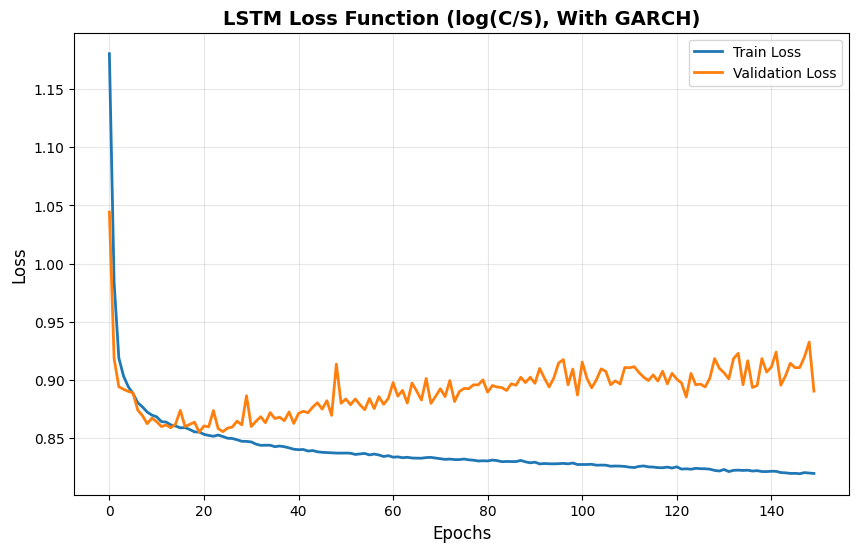

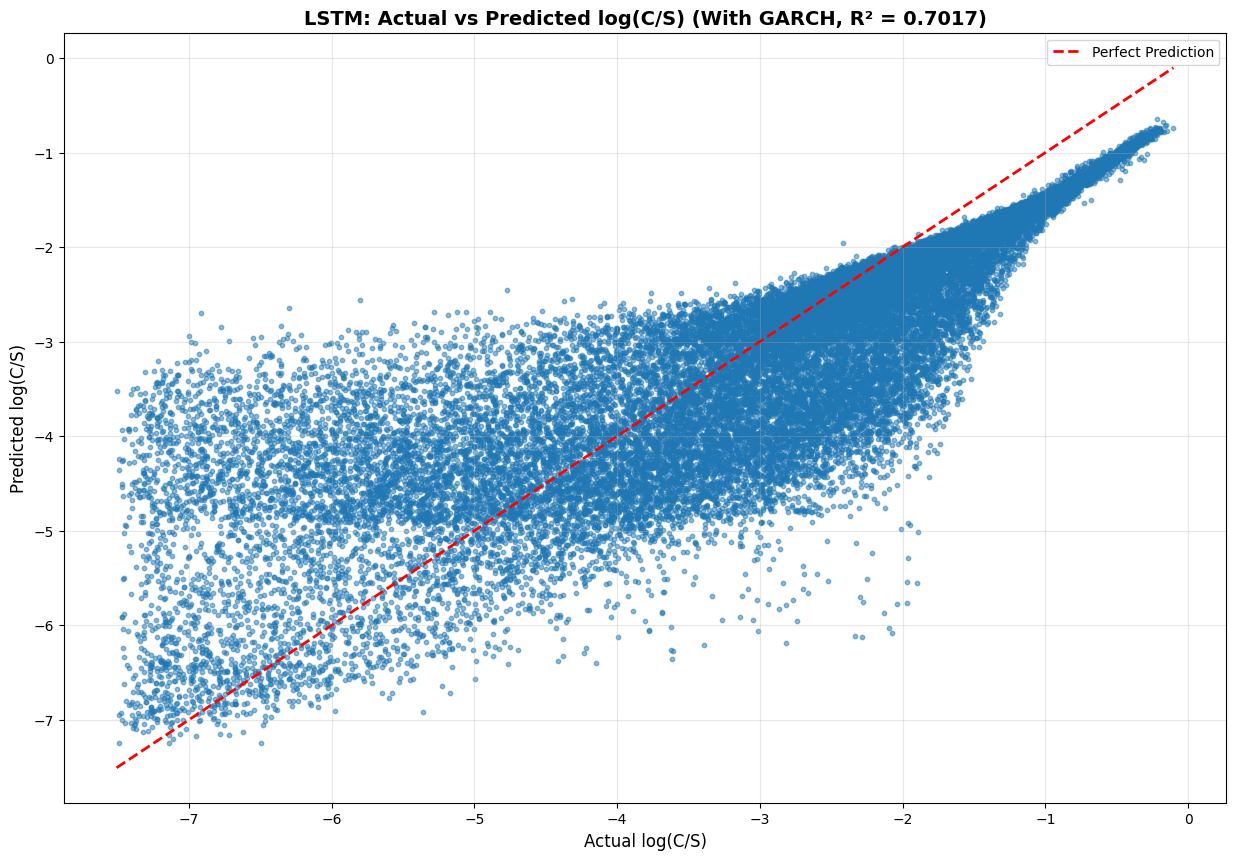


Fraction Error Statistics:
  Min:  -0.610031
  Max:  6.162478
  Mean: 0.210102
  Std:  0.375240


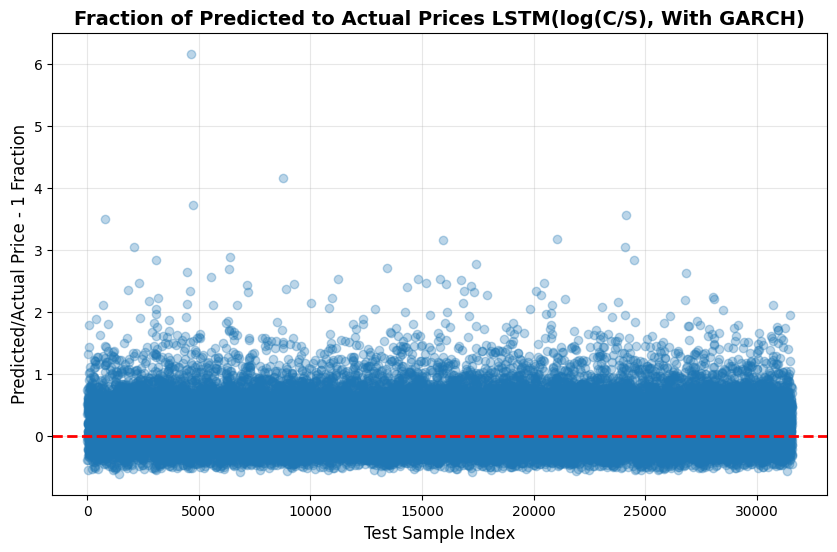

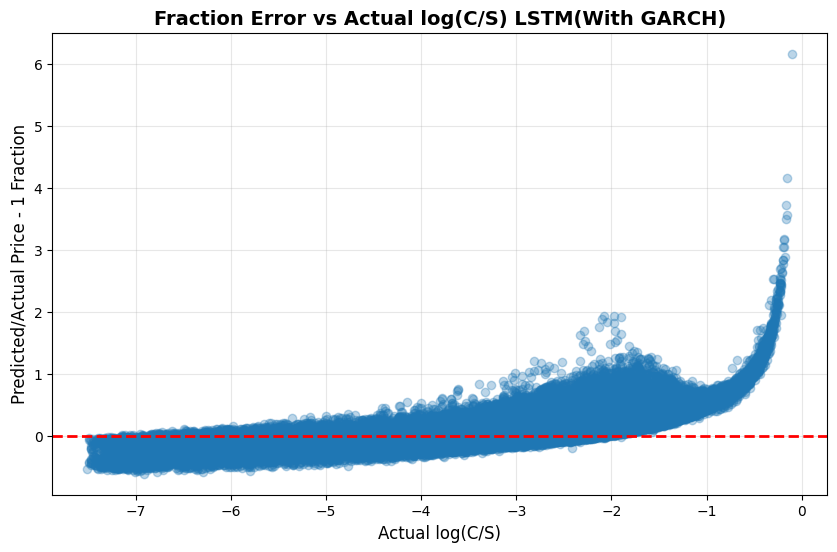

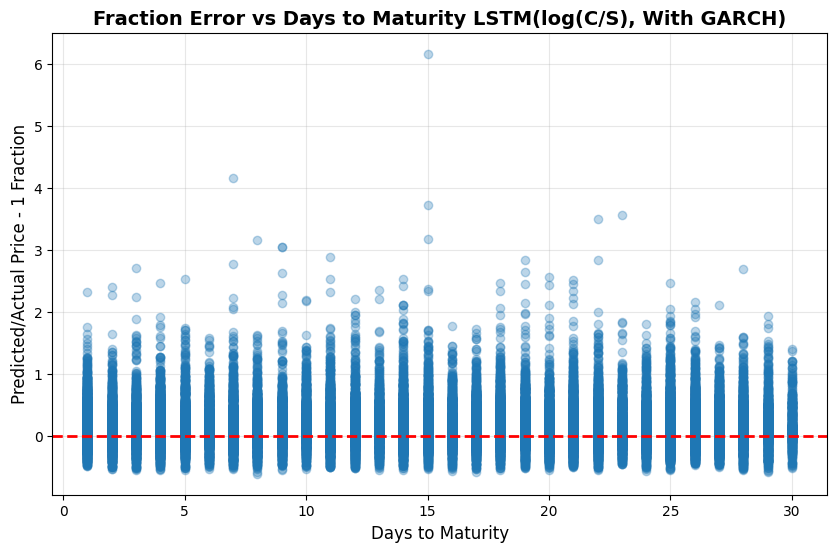


SECTION 2 COMPLETE: All models WITH GARCH trained and evaluated

ALL MODELS COMPLETE!

Summary:
  Section 1 (Without GARCH): 4 models trained
  Section 2 (With GARCH):    4 models trained
  Total: 8 models


In [49]:
# Visualizations for LSTM on log(C/S) (with GARCH)
plt.figure(figsize=(10, 6))
plt.plot(lstm_history_log_cs_with_garch.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in lstm_history_log_cs_with_garch.history:
    plt.plot(lstm_history_log_cs_with_garch.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('LSTM Loss Function (log(C/S), With GARCH)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(15, 10))
plt.scatter(y_test_log_cs_with_garch, y_pred_lstm_log_cs_with_garch, alpha=0.5, s=10)
plt.plot([y_test_log_cs_with_garch.min(), y_test_log_cs_with_garch.max()], 
         [y_test_log_cs_with_garch.min(), y_test_log_cs_with_garch.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual log(C/S)', fontsize=12)
plt.ylabel('Predicted log(C/S)', fontsize=12)
plt.title(f'LSTM: Actual vs Predicted log(C/S) (With GARCH, R² = {r2_lstm_log_cs_with_garch:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

fractions_lstm_log_cs_with_garch = (y_pred_lstm_log_cs_with_garch / y_test_log_reset_garch.values) - 1

print("\nFraction Error Statistics:")
print(f"  Min:  {np.min(fractions_lstm_log_cs_with_garch):.6f}")
print(f"  Max:  {np.max(fractions_lstm_log_cs_with_garch):.6f}")
print(f"  Mean: {np.mean(fractions_lstm_log_cs_with_garch):.6f}")
print(f"  Std:  {np.std(fractions_lstm_log_cs_with_garch):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(fractions_lstm_log_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction of Predicted to Actual Prices LSTM(log(C/S), With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test_log_reset_garch.values, fractions_lstm_log_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Actual log(C/S)', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Actual log(C/S) LSTM(With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(maturity_test_log_with_garch, fractions_lstm_log_cs_with_garch, 'o', alpha=0.3)
plt.xlabel('Days to Maturity', fontsize=12)
plt.ylabel('Predicted/Actual Price - 1 Fraction', fontsize=12)
plt.title('Fraction Error vs Days to Maturity LSTM(log(C/S), With GARCH)', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "=" * 80)
print("SECTION 2 COMPLETE: All models WITH GARCH trained and evaluated")
print("=" * 80)
print("\n" + "=" * 80)
print("ALL MODELS COMPLETE!")
print("=" * 80)
print("\nSummary:")
print("  Section 1 (Without GARCH): 4 models trained")
print("  Section 2 (With GARCH):    4 models trained")
print("  Total: 8 models")
print("=" * 80)
